# <center>Group 2 Final Report</center>

- Boyuan Wu
- Chun Hung Liu
- Patrick Deng
- Subin An





## Project Overview


**Project Description**:

This project aims to develop an **automated pipeline** for generating **short-form, target-centric videos** from full-length landscape videos. The system will incorporate **object detection** and **tracking** to identify and follow key subjects, alongside **video highlight detection** and **summarization**. The final output will be a **concise, subject-focused video** that preserves essential **visual and auditory** elements. For example, a **10-minute surfing session** can be shortened to **30 seconds**, capturing only the target of importance and key highlights. The focus will be an applied implementation that congolmorates several pre-existing models, leveraging their learned features, then apply training on our own dataset.

**Methodology**:

- **Transfer Learning**: Utilize pre-trained Moment-DETR models for both highlight detection and object detection.
- **Model Integration**: Combine object detection CNN with highlight detection into a unified video processing pipeline.
- **Automated Processing**: Ensure seamless generation of short-form videos with minimal manual intervention.


**Modifications from Project Proposal**

Due to the avilability of models and python module updates, we opted for the highlight detection CNN Moment-DETR for transfer learning.

**Resources**:

| Component                   | Source |
|-----------------------------|--------|
| **Highlight Detection Network** | [Moment DETR (GitHub)](https://github.com/jayleicn/moment_detr) |
| **Object Detection CNN**    | [BASNET (GitHub)](https://github.com/xuebinqin/BASNet) |

**Data Collection**

Video data are pre-screned individually to ensure they are of the correct length and that the highlight is available to extract. We then extracted 240 videos for processing. They will all be used for training and validation. Due to the robustness of our pipeline and broad availability of youtube videos and we will automate further data for testing, or even testing on the spot. The full description of the data collection process is explained in the cells below.


**Model Overview**

Our model is aimed to utilize transfer learning and CNN techniques. The model is constructed to learn information in the temporal dimension with the inputs as a pre-processed feature output from Moment-DETR (size 1,n_time,256), the model applys convolution in the temproal dimension then applies a series of MLP that outputs the predicted saliency score per each frame-dt. This process is explained in depth in the subsequent section for model construction.


**Conclusion**
This project leverages existing deep learning techniques to streamline video processing, making it applicable to **sports analysis, content summarization, and media production**.


In [ ]:
import torch
import sys
import os
import re
import json
import random
import yt_dlp
import re
import math
import json
import pandas as pd
import time
from selenium import webdriver
import logging
import argparse
from selenium.webdriver.chrome.options import Options
import numpy as np
from scipy.ndimage import gaussian_filter1d
sys.path.append("./DETR")
# Importing the required libraries from moment detr to extract the highlights
from DETR.run_on_video.data_utils import ClipFeatureExtractor
from DETR.run_on_video.model_utils import build_inference_model
from DETR.utils.tensor_utils import pad_sequences_1d
from DETR.moment_detr.span_utils import span_cxw_to_xx
import torch.nn.functional as F
import numpy as np
from moviepy import VideoFileClip, TextClip, CompositeVideoClip, concatenate_videoclips
import warnings
warnings.filterwarnings("ignore")
logging.getLogger("moviepy").setLevel(logging.CRITICAL)

## Video Transfer Learning

Our data collection pipeline consists of 2 main methods to comptue the labels:
<ol>
  <li>Youtube Highlight detection</li>
  <li>Moment-DETR Prediction</li>
</ol>

We collected a total of 240 youtube videos from 10-20 minutes in length across 3 categories: Sports, stadge performance, and lecture/keynotes. These three categories were selected to balance between visual context importance and audio importance.

The Datacollection pipeline is as follows.

<ol>
  <li>For Youtube Highlight, we created a class **YouTubeWaveformProcessor** that takes an input URL and scrapes the highlight metric from the html, and outputs a normalized saliency score from 0-1 based on user engagement. </li>
  <li>Youtube video is downloaded in an .mp4 file with 720p resolution 24fps.</li>
  <li>For Moment-DETR prediction, the pre-trained model **Moment-DETR** from https://github.com/jayleicn/moment_detr was applied and modified to predict the saliency from the specified .mp4 file. Since the moment-detr model only allows for a maximum of 150s (dt = 2s in a 75 feature output), we segmented the input video then concatenated the output to allow moment-detr to predict longer length videos </li>
  <li>The output are the following:
    <ol style="list-style-type: upper-roman;">
      <li>.jsonl file collection that includes the basic info of the video (link, description, time) and the computed saliency scores from youtube-hilight and moment-detr that will act as the ground truth labels for trainign</li>
      <li>.pt file that contains the features output from the .mp4 file through moment-detr that we will use for training</li>
    </ol>
  </li>
</ol>



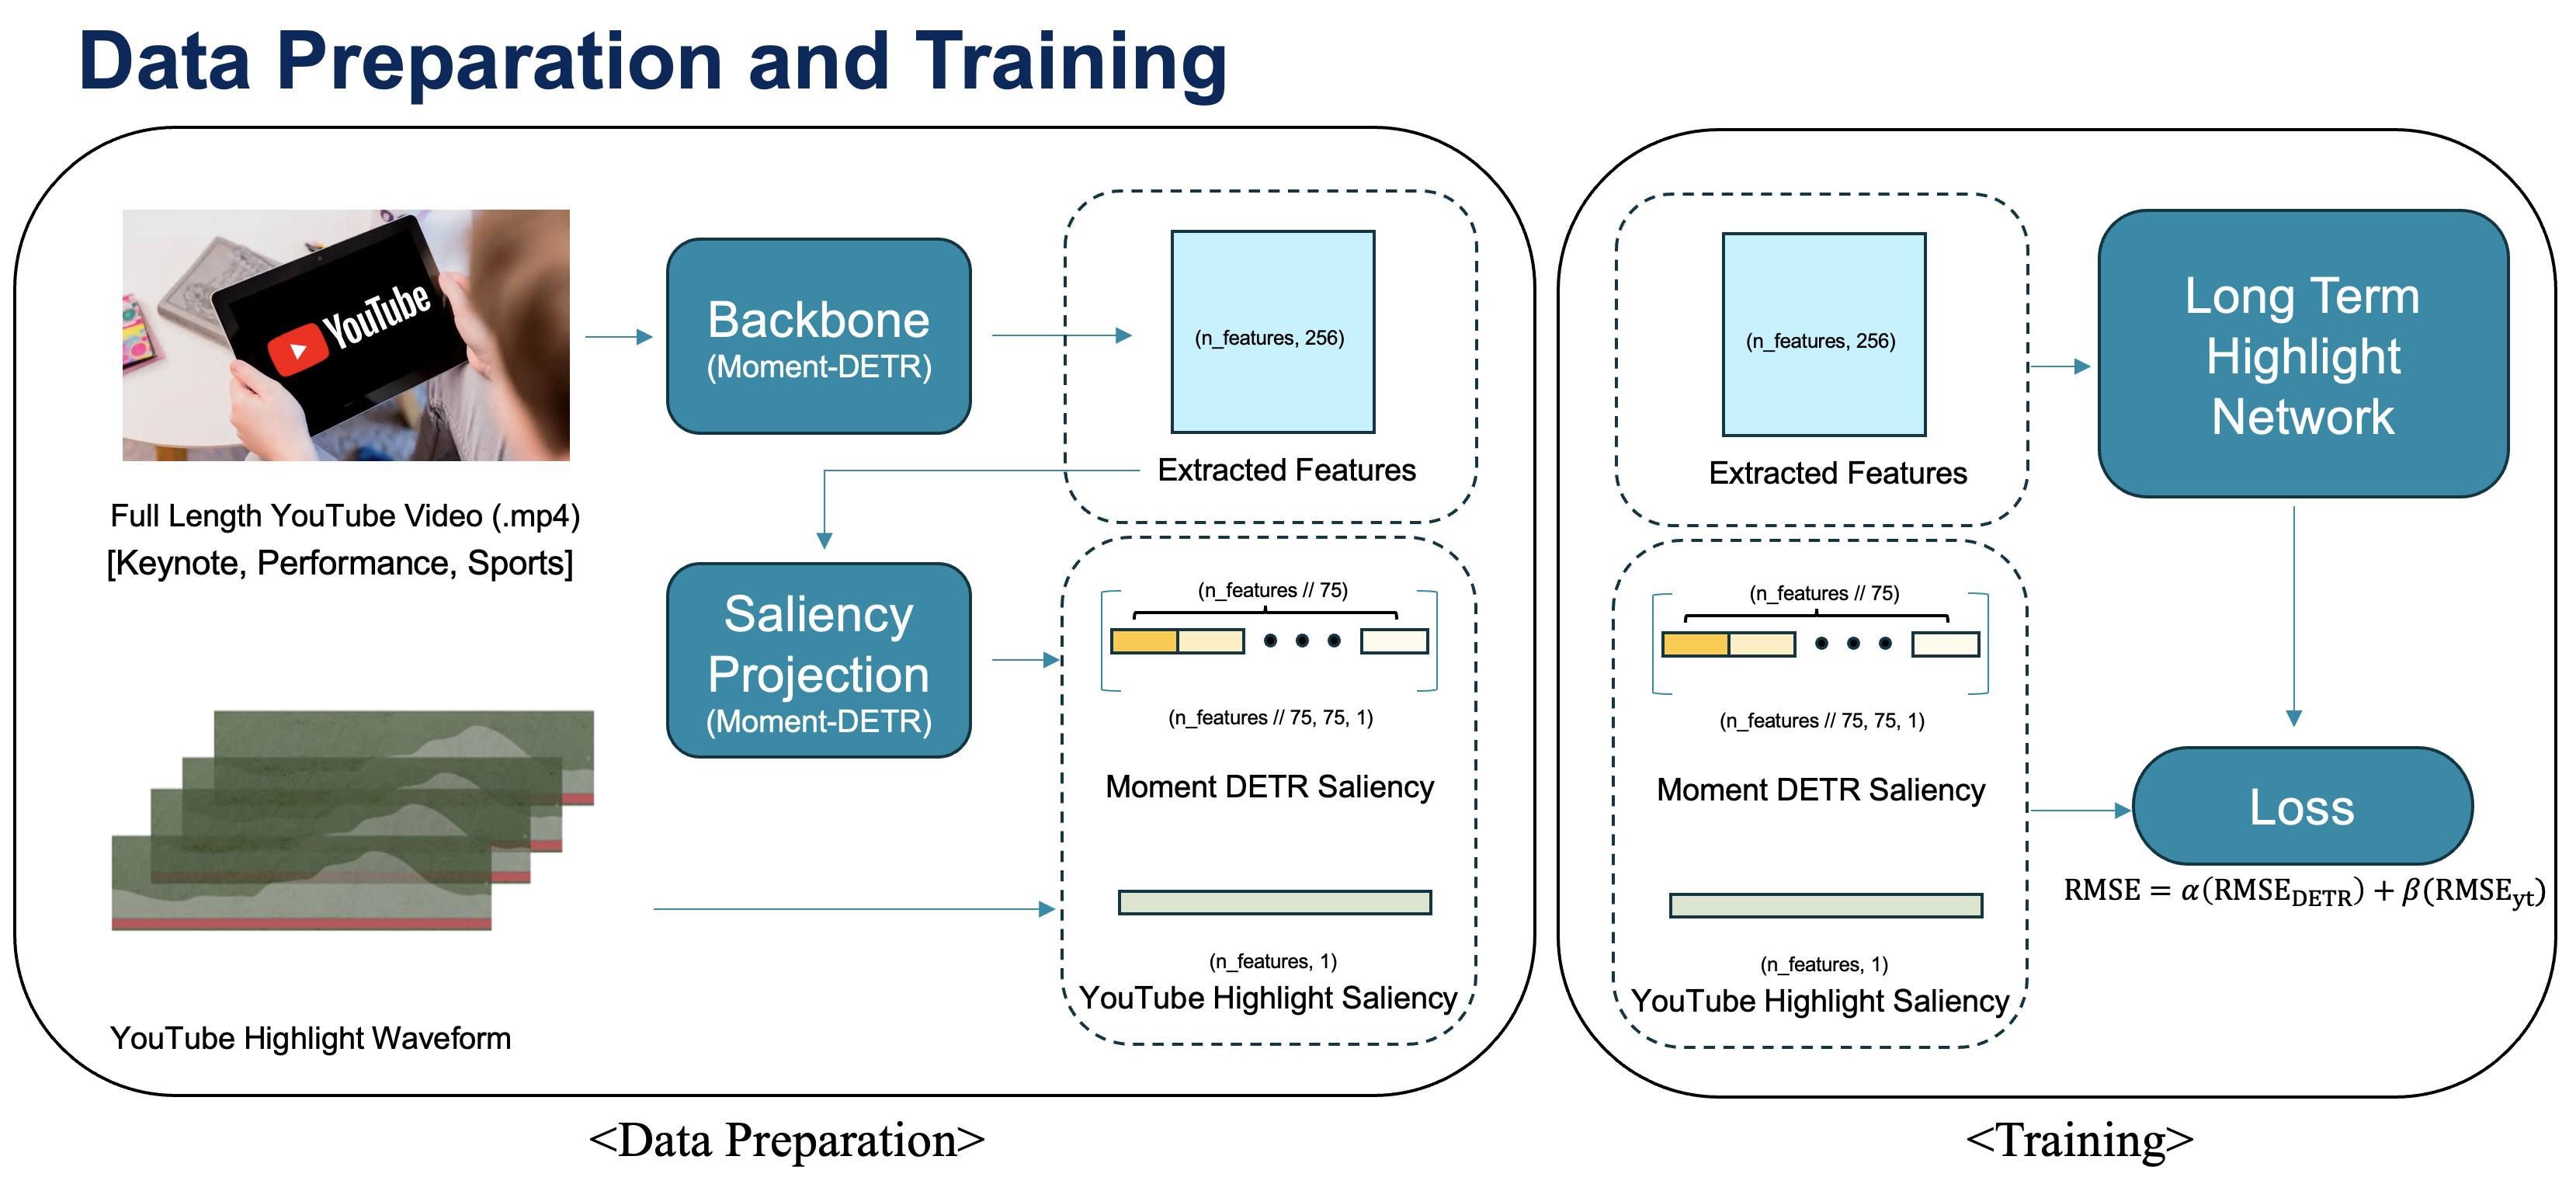

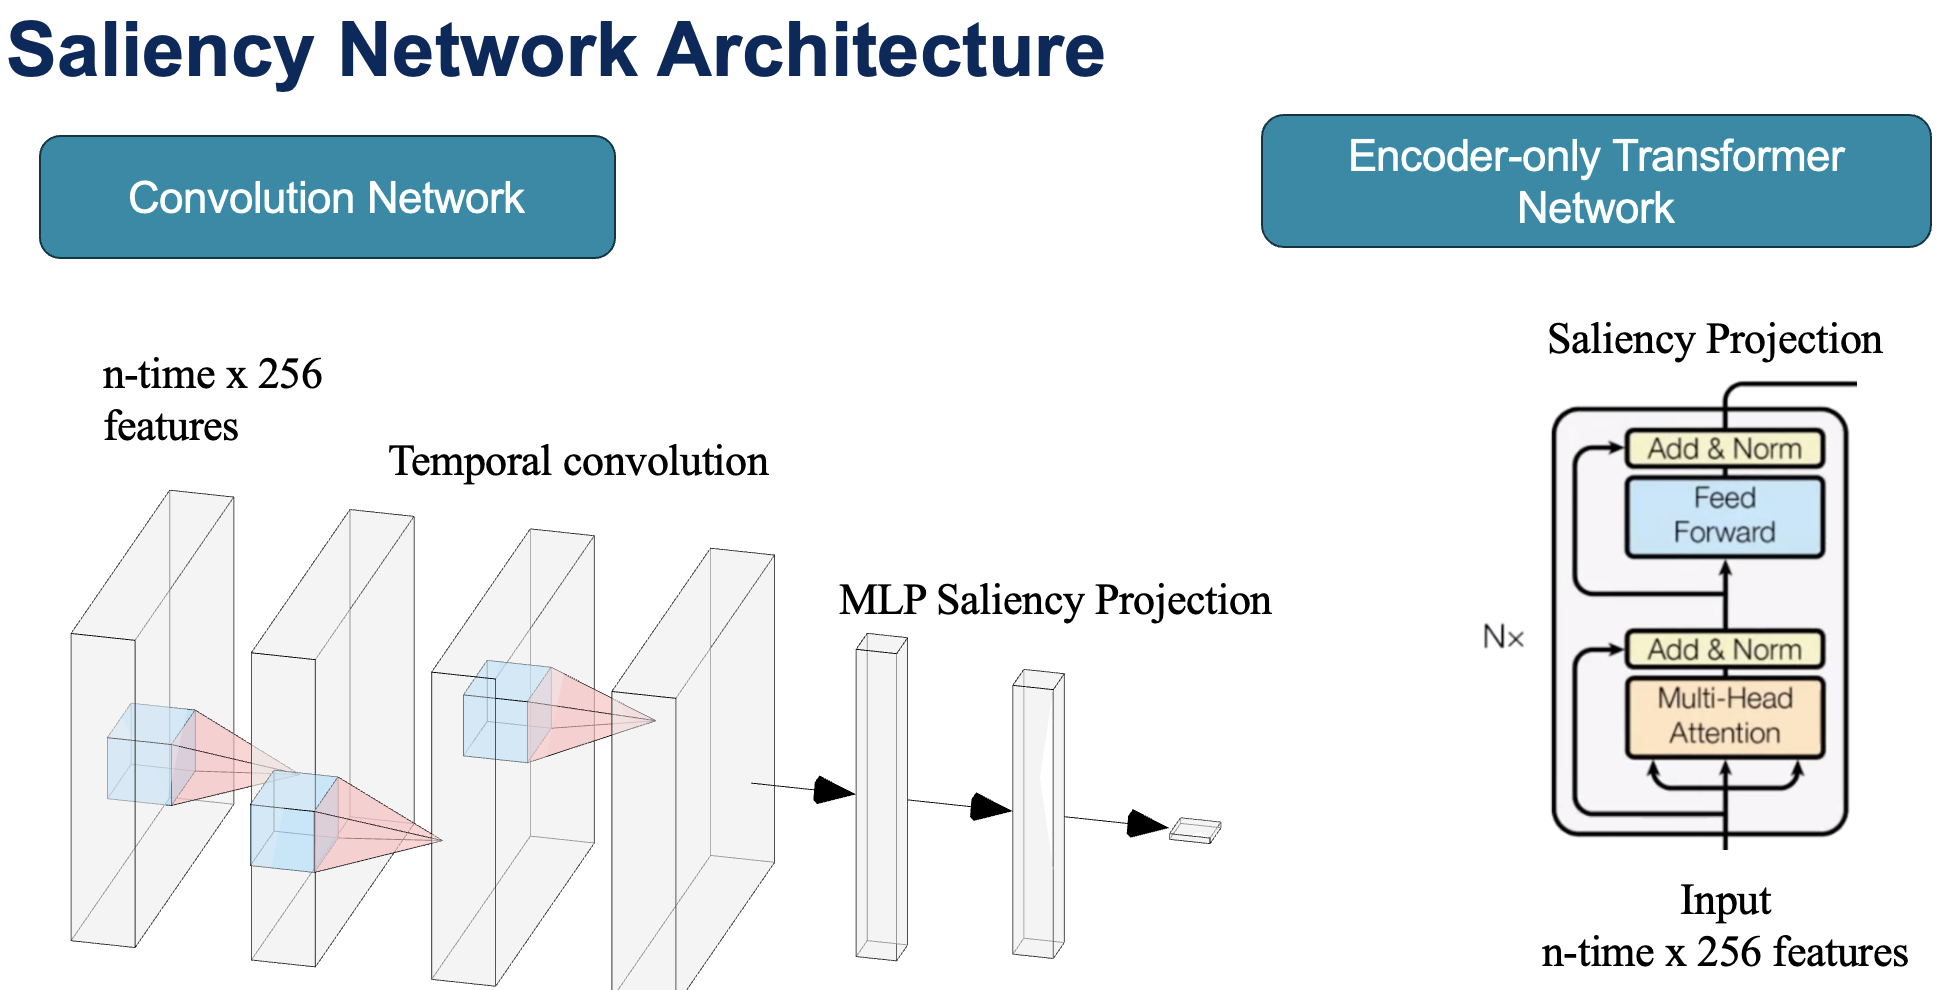

# Dataset structure, Dataloader, Define model

Data are processed and saved in the following structure:
```
data/
├── annotations/
│   ├── database_idols.jsonl
│   ├── database_keynote.jsonl
│   └── database_sport.jsonl
└── output_features/
    ├── Features__4qsQ6OWZsM.pt
    ├── Features__p8k2SQvxul.pt
    ├── Features__YYtXWM3apw.pt
    ├── Features__zWgGX71Iws.pt
    ├── Features__-14Lhw0y1A.pt
    ├── Features__FvrON0OmYc.pt
    ├── Features__-GGq25oP0S4.pt
    ├── Features__0-q1KafFCLU.pt
    ├── Features__0n29H1x5oOA.pt
    ├── ...
```

The dataset is defined in dataset.py, and the model architecture is implemented in model.py.
You can find the training loop and related logic in train.py.

You can train transformer style saliency network with 
```
 python train.py --model_type TransformerNet
```

Below is a sample usage of the dataset, DataLoader, and model:

In [ ]:
import torch
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F
from model import TransformerNet
from dataset import SaliencyDataset, process_batch, process_batch_2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_sa_blocks = 2
lr = 0.0001
weight_decay = 0.0001
batch_size = 4
num_epochs = 10
root_dir = "data"
feature_dir = "data/features"
annotation_dir = "data/annotations"

saliency_proj = nn.Linear(256, 1).to(device)

model = TransformerNet(saliency_proj, num_sa_blocks).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

dataset = SaliencyDataset(root_dir, feature_dir, annotation_dir)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    pass

    """
    this is just for sample code.
    you can find the exact processing data and training code in train.py
    """

# Result / Quantitative

Our train loss plot and visualization of top-10% highlight frames identified by the original YouTube waveform, baseline Moment-DETR, and our proposed approach.

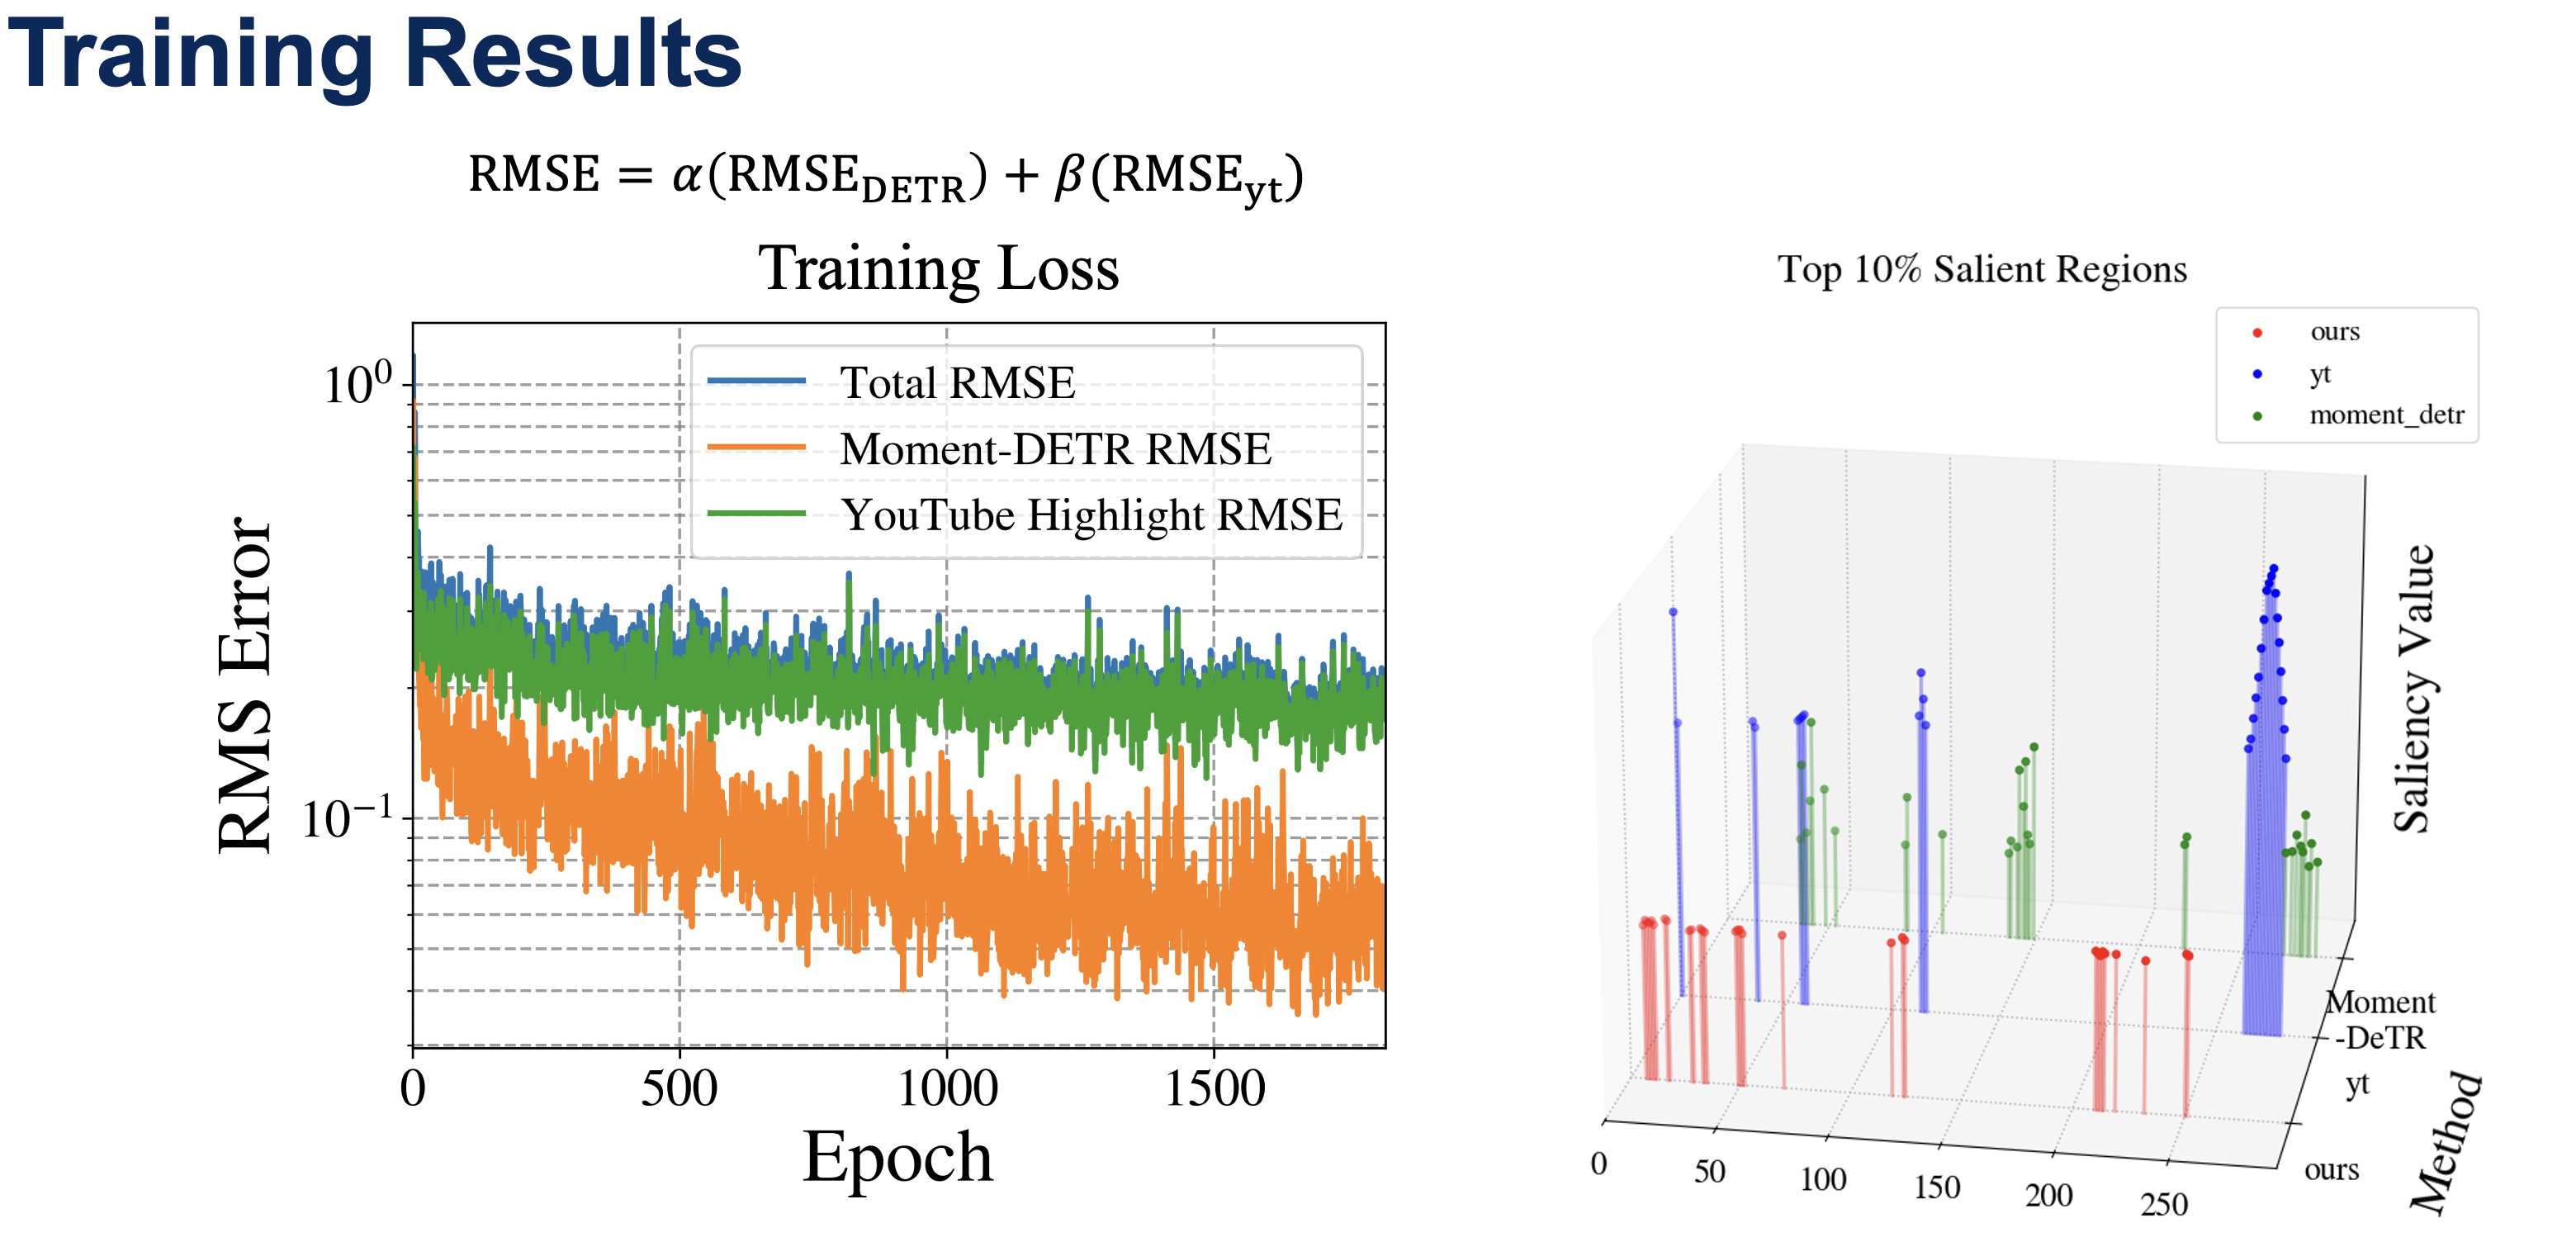

# Result / Qualitative result on new data

Our qualitative result can be found in "result" or in this youtube links https://www.youtube.com/@MIE-q2u/shorts


# Overall Pipeline

We divided our prediction workflow to three separate blocks: pre-processing, prediction, and post-processing.

The preprocessing block downloads the selected youtube video of any timelength as a .mp4 file. We then extract the frames from the video and apply transfer learning from our Moment DETR backbone network to extract the feature embeddings.

The output is a tensor of feature embeddings of size n_fatures x 256 where n_features are sampled at every 2 seconds.

The prediction block computes the saliency score from the feature embeddings with our  Neruonetwork (which we call the Highlight Lens network) which uses a transformer autoencoder.

The post processing block then takes the saliency prediction and crops the original video corresponding to the time stamps highest 10% saliency scores.

We also apply the existing BASnet for object detection to zoom-in on our subject The final output is our shortform edited video. The user interface we built only requires a youtube link as input for a smooth user experience/.

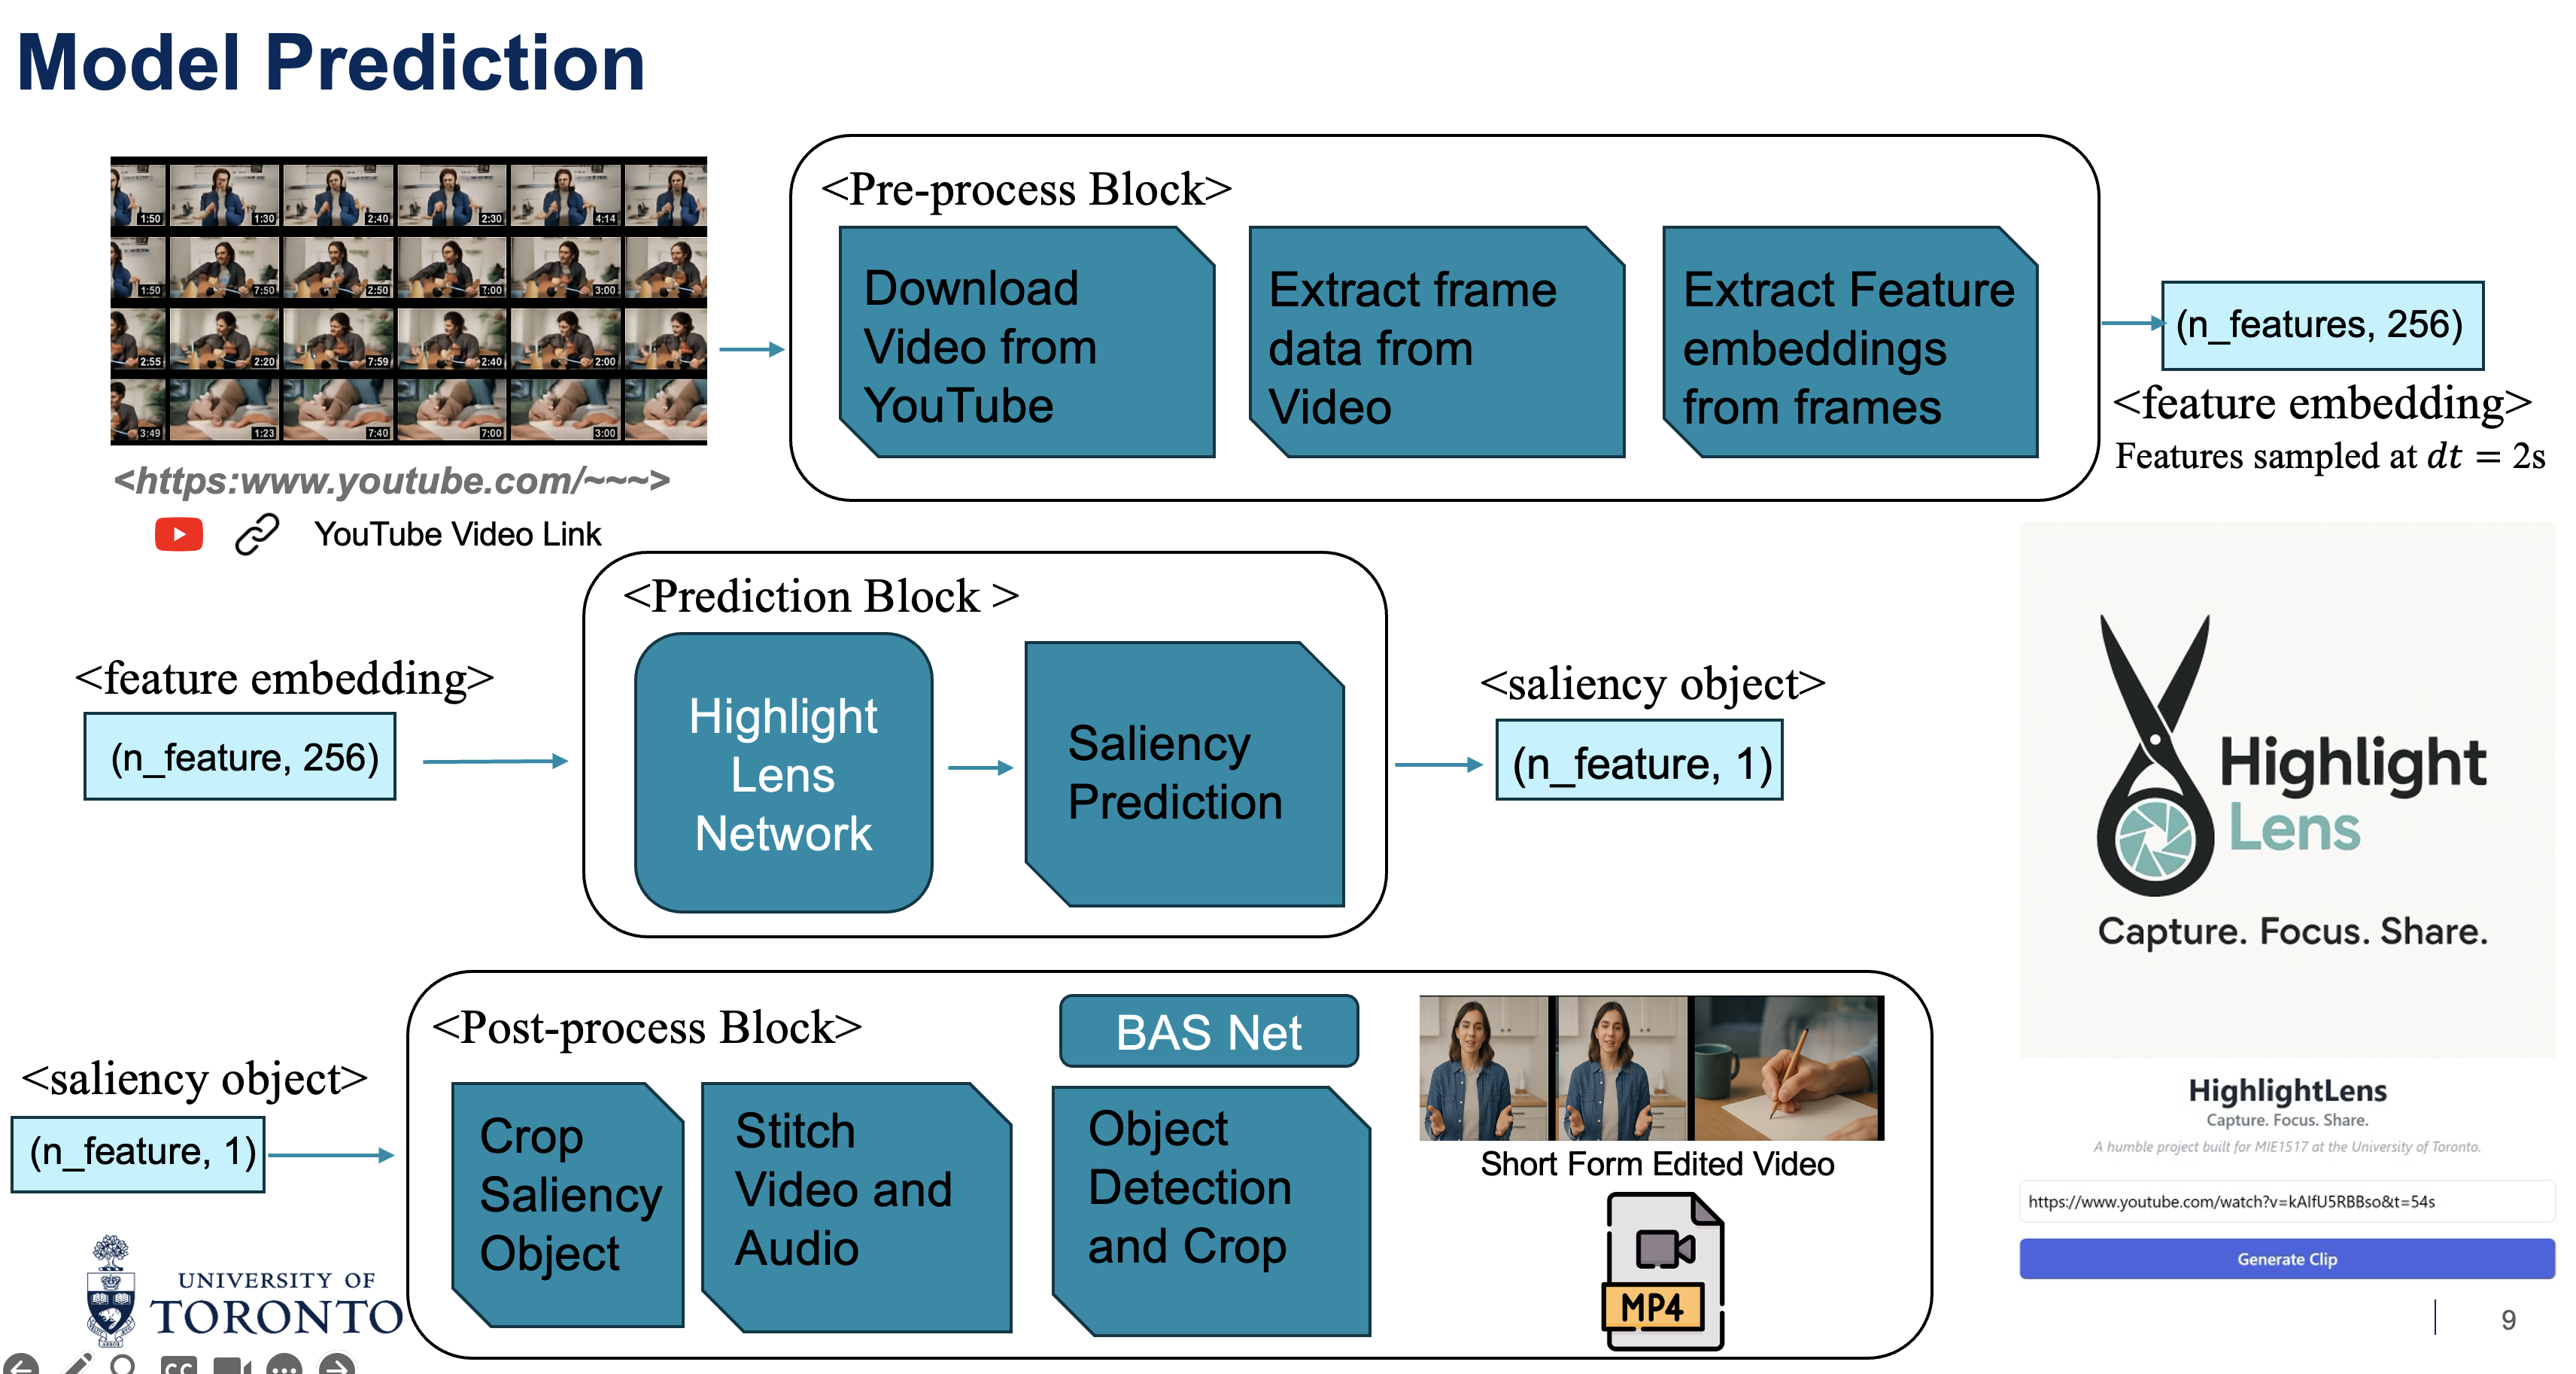

# Discussion

DATA Limitations
 - Dataset bias and generalization issues from limited data size
 - Subjectivity in YouTube highlight waveform as highlights can be illogical due to human nature (HEAD SHOOT)

Model Limitations
 - Highlight detection struggles with videos having broad backgrounds (Expected: SKI, Got: LOGO)
 - Limited understanding of context
 - Keynote-style videos lack scene variety, tough to predict using just visuals - Object detection has trouble with multiple foreground objects

Lessons Learned
  - A larger network does not give better prediction results
  - Subjective ground truth in labelled data can lead to unexpected outcomes - - Model lacks deeper semantic understanding, making it less effective for context-driven highlight scenarios

Future Work
 - Addition of text and audio inputs to provide better context
 - Broader input data sources and more ground truth label sources in aggregate - Combine with modern localization networks such as Segment Anything Model  (SAM) Model can be trained in conjunction with object detection

# Prediction Pipeline

### Youtube Wavefrom Extractor

The YouTubeWaveformProcessor extracts and processes "Most Replayed" data from YouTube videos to identify key moments based on user engagement. It retrieves the video ID, loads the video page using Selenium, and extracts timestamps and intensity scores from YouTube's ytInitialData. The data is stored as a NumPy array, representing time and replay intensity.

To analyze engagement, it interpolates intensity values at regular intervals (default: 2 seconds) and maps them to a saliency scale (1-4), where higher values indicate more replayed segments. Key methods include extracting video IDs, fetching page sources, parsing replay data, and computing saliency scores.

In [ ]:
class YouTubeWaveformProcessor:
    def __init__(self, video_url=None, video_id=None, dt = 2):
        """
        The class is used to process the waveform data given an input YouTube video URL.
        The waveform data is extracted from the 'Most Replayed' data available on the YouTube video page and scraped using Selenium.
        The 'Most Replayed' data is a list of timestamps and normalized intensity values that represent the most replayed sections of the video.
        The waveform data is then interpolated and saliency scores (1-4) are assigned to each timestamp based on the intensity values.
        Args:
            video_url (str): The URL of the YouTube video.
            video_id (str): The YouTube video ID.
            dt (int): The time interval (in seconds) for the interpolated waveform data.
        Outputs:
            waveform (np.array): An array of interpolated waveform data with columns 'time_seconds' and 'intensity'.
            predicted_saliency (list): A list of predicted saliency scores (1-4) for each timestamp in the waveform.
        """
        if video_url:
            self.video_id = self.extract_video_id(video_url)
        elif video_id:
            self.video_id = video_id
        else:
            raise ValueError("Either video_url or video_id must be provided.")
        self.waveform = None
        self.predicted_saliency = None
        self.dt = dt
    @staticmethod
    def extract_video_id(url):
        """Extracts the video ID from a YouTube URL using regex."""
        pattern = r"(?:v=|\/)([0-9A-Za-z_-]{11})"
        match = re.search(pattern, url)
        if match:
            return match.group(1)
        return None

    def fetch_page_source(self):
        """Fetch the page source of a YouTube video using Selenium."""
        chrome_options = Options()
        chrome_options.add_argument("--headless")  # Run headless
        chrome_options.add_argument("--no-sandbox")
        chrome_options.add_argument("--disable-dev-shm-usage")

        # Assuming ChromeDriver is in your system PATH
        driver = webdriver.Chrome(options=chrome_options)
        try:
            url = f"https://www.youtube.com/watch?v={self.video_id}"
            driver.get(url)
            time.sleep(5)  # Allow time for JavaScript to load
            page_source = driver.page_source
            return page_source
        finally:
            driver.quit()

    def extract_most_replayed_data(self, page_source):
        """Extracts 'Most Replayed' data from the page source."""
        match = re.search(r"(?:var\s+)?ytInitialData\s*=\s*({.*?})\s*;", page_source, re.DOTALL)
        if not match:
            raise ValueError("Could not find ytInitialData in the page source.")
        data = json.loads(match.group(1))
        markers = None
        try:
            # Navigate to the macroMarkersListEntity
            framework_updates = data.get("frameworkUpdates", {})
            if framework_updates:
                mutations = framework_updates.get("entityBatchUpdate", {}).get("mutations", [])
                for mutation in mutations:
                    # This entityKey might be specific; adjust if needed
                    if mutation.get("entityKey") == "EgpIRUFUU0VFS0VSIJICKAE%3D":
                        markers = mutation["payload"]["macroMarkersListEntity"]["markersList"]["markers"]
                        break
            if not markers:
                raise ValueError("No 'Most Replayed' data found in ytInitialData.")
        except (KeyError, TypeError) as e:
            raise ValueError(f"Error parsing data: {str(e)}")

        # Convert markers to lists of timestamps (in seconds) and normalized intensity values
        timestamps = [int(marker["startMillis"]) / 1000 for marker in markers]
        intensities = [marker["intensityScoreNormalized"] for marker in markers]
        return timestamps, intensities

    def process_video(self):
        """Processes a single video to fetch its waveform data."""
        print(f"Processing video ID: {self.video_id}")
        try:
            print("Fetching page source...")
            page_source = self.fetch_page_source()
            print("Extracting 'Most Replayed' data...")
            timestamps, intensities = self.extract_most_replayed_data(page_source)
            self.total_time = timestamps[-1]  # Duration of the video in seconds
            self.time = timestamps
            self.waveform = np.array(
                list(zip(timestamps, intensities)),
                dtype=[("time_seconds", float), ("intensity", float)]
            )
            return {"video_id": self.video_id, "waveform": self.waveform}
        except Exception as e:
            print(f"No waveform data for video ID {self.video_id}: {str(e)}")
            self.waveform = "NA"
            return {"video_id": self.video_id, "waveform": "NA"}
    def calculate_saliency(self):
        """Interpolates waveform data and calculates normalized saliency scores (1-4)."""
        if self.waveform is None or isinstance(self.waveform, str):
            raise ValueError("Waveform data is not available.")

        # Ensure required attributes exist
        if not hasattr(self, 'total_time') or not hasattr(self, 'dt'):
            raise ValueError("total_time or dt is not defined.")
        # Extract waveform intensity values and their corresponding time stamps
        time_original = self.time
        intensity_original = self.waveform["intensity"]

        # Define new interpolated time grid based on total_time and dt
        time_interpolated = np.arange(0, math.ceil(self.total_time / 2) * 2, self.dt)

        # Interpolate intensity values over the new time grid
        self.interpolated_intensity= np.interp(time_interpolated, time_original, intensity_original)

        # Map interpolated intensity values to saliency scores (1-4)
        saliency_scores = np.empty_like(self.interpolated_intensity, dtype=int)
        saliency_scores[self.interpolated_intensity < 0.25] = 1
        saliency_scores[(self.interpolated_intensity >= 0.25) & (self.interpolated_intensity < 0.5)] = 2
        saliency_scores[(self.interpolated_intensity >= 0.5) & (self.interpolated_intensity< 0.75)] = 3
        saliency_scores[self.interpolated_intensity >= 0.75] = 4
        # Store the interpolated saliency values
        self.predicted_saliency = saliency_scores.tolist()
        return self.predicted_saliency, self.interpolated_intensity

### Moment DETR Predictor

The following class takes in the pre-trained weights from moment-detr and predicts on the input video

The outputs are the predicted saliency scores and the features

In [ ]:

class MomentDETRPredictor:
    def __init__(self, ckpt_path, clip_model_name_or_path="ViT-B/32", device="cpu",dt:int=2):
        self.clip_len = dt  # seconds
        self.device = device
        print("Loading feature extractors...")
        self.feature_extractor = ClipFeatureExtractor(
            framerate=1/self.clip_len, size=224, centercrop=True,
            model_name_or_path=clip_model_name_or_path, device=device
        )
        print("Loading trained Moment-DETR model...")
        self.model = build_inference_model(ckpt_path).to(self.device)

    @torch.no_grad()
    def localize_moment(self, video_path, query_list):
        """
        Args:
            video_path: str, path to the video file
            query_list: List[str], each str is a query for this video
        """
        # construct model inputs
        n_query = len(query_list)
        video_feats = self.feature_extractor.encode_video(video_path)
        video_feats = F.normalize(video_feats, dim=-1, eps=1e-5)

        n_frames = len(video_feats)
        # add tef
        tef_st = torch.arange(0, n_frames, 1.0) / n_frames
        tef_ed = tef_st + 1.0 / n_frames
        tef = torch.stack([tef_st, tef_ed], dim=1).to(self.device)  # (n_frames, 2)
        video_feats = torch.cat([video_feats, tef], dim=1)
        assert n_frames <= 75, "The positional embedding of this pretrained MomentDETR only support video up " \
                               "to 150 secs (i.e., 75 2-sec clips) in length"
        video_feats = video_feats.unsqueeze(0).repeat(n_query, 1, 1)  # (#text, T, d)
        video_mask = torch.ones(n_query, n_frames).to(self.device)
        query_feats = self.feature_extractor.encode_text(query_list)  # #text * (L, d)
        query_feats, query_mask = pad_sequences_1d(
            query_feats, dtype=torch.float32, device=self.device, fixed_length=None)
        query_feats = F.normalize(query_feats, dim=-1, eps=1e-5)
        model_inputs = dict(
            src_vid=video_feats,
            src_vid_mask=video_mask,
            src_txt=query_feats,
            src_txt_mask=query_mask
        )

        # decode outputs
        outputs = self.model(**model_inputs)
        feat_before_saliency = outputs["feat_before_proj"]  # (bsz, L, d)
        # #moment_queries refers to the positional embeddings in MomentDETR's decoder, not the input text query
        prob = F.softmax(outputs["pred_logits"], -1)  # (batch_size, #moment_queries=10, #classes=2)
        scores = prob[..., 0]  # * (batch_size, #moment_queries)  foreground label is 0, we directly take it
        pred_spans = outputs["pred_spans"]  # (bsz, #moment_queries, 2)
        _saliency_scores = outputs["saliency_scores"].half()  # (bsz, L)
        saliency_scores = []
        valid_vid_lengths = model_inputs["src_vid_mask"].sum(1).cpu().tolist()
        for j in range(len(valid_vid_lengths)):
            _score = _saliency_scores[j, :int(valid_vid_lengths[j])].tolist()
            _score = [round(e, 4) for e in _score]
            saliency_scores.append(_score)

        # compose predictions
        predictions = []
        video_duration = n_frames * self.clip_len
        for idx, (spans, score) in enumerate(zip(pred_spans.cpu(), scores.cpu())):
            spans = span_cxw_to_xx(spans) * video_duration
            # # (#queries, 3), [st(float), ed(float), score(float)]
            cur_ranked_preds = torch.cat([spans, score[:, None]], dim=1).tolist()
            cur_ranked_preds = sorted(cur_ranked_preds, key=lambda x: x[2], reverse=True)
            cur_ranked_preds = [[float(f"{e:.4f}") for e in row] for row in cur_ranked_preds]
            cur_query_pred = dict(
                query=query_list[idx],  # str
                vid=video_path,
                pred_relevant_windows=cur_ranked_preds,  # List([st(float), ed(float), score(float)])
                pred_saliency_scores=saliency_scores[idx]  # List(float), len==n_frames, scores for each frame
            )
            predictions.append(cur_query_pred)

        return predictions, feat_before_saliency

### Video Pretraining Class

The following class combines the above and handles the data extraction process. It is designeed to handle an input link to process the pipeline and exports the requried data.

In [ ]:
class VideoPretraining:
    def __init__(self, output_path='.', metadata_name:str="metadata.jsonl", qid:int=None, video_proc:bool=False,
                 segment_duration:int=150, clip:bool=False, clip_duration:int=30, delete_mp4:bool=False):
        """
            Class object for the video processing pipeline to download, segment, and process videos.

            The video is downloaded in the mp4 format. then segmented to 150s segments (default) for processing in the
            DETR model. each segment is processed to extract the youtube highlights and the saliency scores are calculated.
            The output is a summary video of the highlights and the metadata file with the saliency scores and the
            concatenated pytorch tensor of the features
        Args:
            output_path (str): Directory where the metadata are saved
            metadata_name.
            qid (int): Query ID for the video.
            video_proc (bool): Whether to run the video processing to extract highlights
            segment_duration (int): Duration of each segment for processing (150s here).
            clip (bool): Whether to clip the video to extract a middle segment.
            clip_duration (int): Seconds to clip from the start and end if clipping.
            delete_mp4 (bool): Whether to delete the original mp4 file after clipping.
        """
        self.output_path = os.path.join(os.getcwd(), output_path)
        if not os.path.exists(self.output_path):
            os.makedirs(self.output_path, exist_ok=True)
        if not os.path.exists(os.path.join(self.output_path,'annotations')):
            os.makedirs(os.path.join(self.output_path,'annotations'), exist_ok=True)
        self.metadata_path = os.path.join(self.output_path, 'annotations', metadata_name)
        self.clip = clip
        self.clip_duration = clip_duration
        self.segment_duration = segment_duration
        self.run_video_processing = video_proc
        self.delete_mp4 = delete_mp4

        self.features_path = os.path.join(self.output_path,'features')
        if not os.path.exists(self.features_path ):
            os.makedirs(self.features_path , exist_ok=True)
        self.video_path = os.path.join(self.output_path,'videos')
        if not os.path.exists(self.video_path):
            os.makedirs(self.video_path, exist_ok=True)

    @staticmethod
    def sanitize_filename(title):
        """
        Remove invalid characters from a filename and remove spaces/commas.
        """
        sanitized = re.sub(r'[\\/*?:"<>#!|]', '_', title)
        sanitized = sanitized.replace(" ", "").replace(",", "")
        sanitized = sanitized.lower()
        return sanitized

    @staticmethod
    def extract_video_id(url):
        """Extracts the video ID from a YouTube URL using regex."""
        pattern = r"(?:v=|\/)([0-9A-Za-z_-]{11})"
        match = re.search(pattern, url)
        if match:
            return match.group(1)
        return None

    def download_video(self, url):
        """
        Download a video from the given URL and optionally clip it.
        Returns a tuple: (metadata_path, video_file_path)
        """
        ydl_opts = {
            'format': 'bestvideo[height<=720]+bestaudio/best[height<=720]',
            'outtmpl': os.path.join(self.video_path, '%(title)s.%(ext)s'),
            'merge_output_format': 'mp4',
            "quiet": True,
            "no_warnings": True,
            'postprocessors': [{'key': 'FFmpegVideoConvertor','preferedformat': 'mp4',}],
            #'postprocessor_args': ['-vf', 'fps=24'],
        }
        # ydl_opts = {
        #     'format': 'bestvideo[height<=720]+bestaudio/best[height<=720]',
        #     'outtmpl': os.path.join(self.video_path, '%(title)s.%(ext)s'),
        #     #'merge_output_format': 'mp4',
        #     "quiet": True,
        #     "no_warnings": True,
        # }
        try:
            with yt_dlp.YoutubeDL(ydl_opts) as ydl:
                info = ydl.extract_info(url, download=False)
                title = info.get('title', 'Unknown_Title')
                duration = info.get('duration', 0)
            sanitized_title = self.sanitize_filename(title)
            self.qid = self.qid if self.qid is not None else random.randint(1000, 9999)
            new_opts = ydl_opts.copy()
            print(f"Downloading video: {sanitized_title}")
            new_opts['outtmpl'] = f'{self.video_path}/{sanitized_title}.%(ext)s'

            # Downloading
            try:
                with yt_dlp.YoutubeDL(new_opts) as ydl:
                    ydl.download([url])
                print("Download complete!")
            except Exception as e:
                print(f"Error downloading video: {e}")
                return None

            video_filename = f"{sanitized_title}.mp4"
            video_file_path = os.path.join(self.video_path, video_filename)
            # Clip the video if requested.
            if self.clip:
                video_clip = VideoFileClip(video_file_path)
                if duration <= 60:
                    print("Video is too short to extract a middle segment after removing 30 seconds from each end.")
                    video_clip.close()
                    return None, None

                # Extract the middle segment.
                middle_clip = video_clip.subclipped(self.clip_duration, duration - self.clip_duration)
                final_video = CompositeVideoClip([middle_clip])
                video_file_path = video_file_path.replace(".mp4", "_clipped.mp4")
                final_video.write_videofile(video_file_path, codec="libx264")
                new_duration = duration - 2 * self.clip_duration
                print(f"Middle segment extracted successfully! New duration: {new_duration:.2f} seconds")
                middle_clip.close()
                duration = new_duration
                video_clip.close()
            else:
                print(f"Clipping not requested.")

            self.sanitized_title, self.url, self.duration, self.vid = sanitized_title, url, duration, self.extract_video_id(url)
            # Save metadata.
            metadata_path = os.path.join(self.output_path,self.metadata_path) if self.metadata_path is not None else os.path.join(self.output_path, sanitized_title + ".jsonl")
            metadata = {
                "qid": self.qid,
                "query": self.sanitized_title,
                "duration": self.duration,
                "url": self.url,
                "video_id": self.vid,
            }
            with open(metadata_path, "a") as f:
                json.dump(metadata, f)
                f.write("\n")
        except Exception as e:
            print("An error occurred during download:", e)
            return None, None

        return metadata_path, video_file_path

    def segment_video(self, video_path):
        """
        Splits a long video into segments of self.segment_duration seconds.
        Returns a list of tuples: (segment_file_path, start_time, end_time)
        """
        segments = []
        # Open the video once to get the duration.
        video_clip = VideoFileClip(video_path)
        video_duration = video_clip.duration
        video_clip.close()  # We'll reopen per segment
        # Create segments with a fixed duration (e.g., 150s)
        for start in range(0, int(video_duration), self.segment_duration):
            end = min(start + self.segment_duration, video_duration)
            # Open the video file anew for each segment.
            clip = VideoFileClip(video_path)
            segment_clip = clip.subclipped(start, end)
            segment_file_path = video_path.replace(".mp4", f"_segment_{start}.mp4")
            segment_clip.write_videofile(segment_file_path, codec="libx264", fps=24)
            segments.append((segment_file_path, start, end))
            segment_clip.close()
            clip.close()
        print(f"Video segmented into {len(segments)} segments.")
        return segments

    def predict_video_segment(self, segment_video_path,segment_index):
        """
        Run Moment-DETR prediction on a video segment.
        Returns queries, predictions, dt, segment duration, and predicted saliency scores.
        """
        # Create a dummy query for this segment.
        video_clip = VideoFileClip(segment_video_path)
        seg_duration = video_clip.duration
        video_clip.close()
        query = {"query": "Segment", "duration": seg_duration}
        queries = [query]
        dt = 2  # time interval used for prediction
        ckpt_path = "./ckpt/moment_detr/model_best.ckpt"
        clip_model_name_or_path = "ViT-B/32"
        moment_detr_predictor = MomentDETRPredictor(
            ckpt_path=ckpt_path,
            clip_model_name_or_path=clip_model_name_or_path,
            device="cpu",
            dt=dt
        )
        predictions, features = moment_detr_predictor.localize_moment(
            video_path=segment_video_path, query_list=[query["query"]])
        # Optionally save features:
        #feature_filename = f"dummy_features_{segment_index}.pt"
        #torch.save(features, feature_filename)
        # Normalize and map the saliency scores.
        arr = np.array(predictions[0]['pred_saliency_scores'])
        self.pred_saliency = arr
        normalized = (arr + 1) / 2  # values now in [0, 1]
        mapped = np.empty_like(normalized, dtype=int)
        mapped[normalized < 0.25] = 1
        mapped[(normalized >= 0.25) & (normalized < 0.5)] = 2
        mapped[(normalized >= 0.5) & (normalized < 0.75)] = 3
        mapped[normalized >= 0.75] = 4
        predicted_saliency = mapped.tolist()
        return queries, predictions, dt, seg_duration, predicted_saliency, features,arr

    def process_video_summary(self, video_path, duration, dt, predictions, queries, target_time: int = 10, output_suffix=""):
        """
        Generate a summary for a video (or segment) by selecting top saliency-score clips.
        The output_suffix allows naming different summary files for each segment.
        """
        target_duration_sec = target_time / 100 * duration
        if target_duration_sec >= 0.11 * duration:
            print("Error: Target summary time must be less than 10% of the original video duration.")
            return None

        saliency_scores = predictions[0]['pred_saliency_scores']
        saliency_array = np.array(saliency_scores)
        num_clips_needed = int(np.ceil(target_duration_sec / dt))
        top_indices = np.argsort(saliency_array)[-num_clips_needed:]
        top_indices = np.sort(top_indices)  # Ensure chronological order
        print(f"Selected clip indices for segment{output_suffix}: {top_indices}")

        video_clip = VideoFileClip(video_path)
        clip_list = []
        for idx in top_indices:
            start_time = idx * dt
            end_time = min((idx + 1) * dt, duration)
            print(f"Extracting clip from {start_time} to {end_time} seconds for segment{output_suffix}.")
            clip = video_clip.subclipped(start_time, end_time)
            clip_list.append(clip)

        if clip_list:
            summary_clip = concatenate_videoclips(clip_list)
            base_name = os.path.splitext(os.path.basename(video_path))[0]
            output_summary_path = os.path.join(self.output_video_path, f"{base_name}_highlighted{output_suffix}.mp4")
            summary_clip.write_videofile(output_summary_path, codec="libx264")
            print(f"Summary video for segment{output_suffix} saved as {output_summary_path}")
            summary_clip.close()
            video_clip.close()
            return output_summary_path
        else:
            print("No clips selected for summary in this segment.")
            video_clip.close()
            return None

    def add_saliency_to_metadata(self, metadata_path, target_qid):
        """
        Update metadata by adding the predicted saliency scores.
        """
        updated_records = []
        record_found = False
        with open(metadata_path, "r") as f:
            for line in f:
                record = json.loads(line)
                if record.get("qid") == target_qid:
                    if len(self.combined_saliency) < len(self.yt_highlight):
                        self.combined_saliency.extend([1] * (len(self.yt_highlight) - len(self.combined_saliency)))
                    elif len(self.combined_saliency) > len(self.yt_highlight):
                        self.yt_highlight.extend([1] * (len(self.combined_saliency) - len(self.yt_highlight)))
                    record["predicted_saliency"] = self.combined_saliency
                    record["full_saliency"] = self.whole_saliency
                    record["yutube_highlight"] = self.yt_highlight
                    record["full_youtube_intensity"] = self.yt_intensity.tolist()
                    record_found = True
                updated_records.append(record)

        if not record_found:
            print(f"No record found with qid {target_qid}")

        with open(metadata_path, "w") as f:
            for record in updated_records:
                json.dump(record, f)
                f.write("\n")

    def run_segmented_pipeline(self, url, qid):
        """
        Full pipeline for longer videos:
        1. Download the video.
        2. Split it into segments (150s each).
        3. For each segment:
            - Run Moment-DETR prediction (which returns features, saliency, etc.).
            - Process and generate a summary clip.
            - Collect the predicted saliency scores and features.
        4. Stitch together the summary clips and update metadata.
        5. Combine all features into one tensor.
        """
        # 1. Download the video.
        self.qid = qid
        print(f"\n{' Beginning Video Pretraining Pipeline ':=^100}\n")
        metadata_path, video_file_path = self.download_video(url)
        if not metadata_path or not video_file_path:
            print("Download failed.")
            return

        # 2. Segment the video.
        segments = self.segment_video(video_file_path)

        self.combined_saliency = []
        self.whole_saliency = []
        combined_feature_list = []
        summary_segments_paths = []

        # 3. Loop through each segment to run prediction and generate a summary clip
        for idx, (segment_path, seg_start, seg_end) in enumerate(segments):
            print(f"Processing segment {idx+1}: {segment_path}")
            # Run prediction on the segment (ensure predict_video_segment returns 6 values)
            queries, predictions, dt, seg_duration, predicted_saliency, features,arr = self.predict_video_segment(segment_path, idx+1)
            self.combined_saliency.extend(predicted_saliency)
            self.whole_saliency.extend(arr)
            combined_feature_list.append(features)
            if self.run_video_processing:
                # Generate a summary clip for the segment
                summary_path = self.process_video_summary(
                    segment_path, seg_duration, dt, predictions, queries,
                    target_time=10, output_suffix=f"_seg{idx+1}"
                )
                if summary_path:
                    summary_segments_paths.append(summary_path)

        # 4. Stitch all summary segments into one video.
        if summary_segments_paths:
            clips = [VideoFileClip(p) for p in summary_segments_paths]
            stitched_clip = concatenate_videoclips(clips)
            stitched_output_path = os.path.join(self.output_path, f"Summary_{self.sanitized_title}.mp4")
            stitched_clip.write_videofile(stitched_output_path, codec="libx264",fps=24)
            print(f"Stitched summary video saved as {stitched_output_path}")
            stitched_clip.close()
            for clip in clips:
                clip.close()
            for clip_path in summary_segments_paths:
                try:
                    if os.path.exists(clip_path):
                        os.remove(clip_path)
                        print(f"Deleted segment clip: {clip_path}")
                    else:
                        print(f"File not found: {clip_path}")
                except Exception as e:
                    print(f"Error deleting {clip_path}: {e}")
        else:
            print("No summary segments to stitch.")

        for segment_path, _, _ in segments:
            try:
                if os.path.exists(segment_path):
                    os.remove(segment_path)
                    print(f"Deleted segment: {segment_path}")
                else:
                    print(f"File not found: {segment_path}")
            except Exception as e:
                print(f"Error deleting {segment_path}: {e}")
        # 5. Combine the features from all segments.
        # Assuming features are tensors that can be concatenated along dim=0:
        combined_features = torch.cat(combined_feature_list, dim=1)
        combined_features_path = os.path.join(self.features_path, "Features_"+self.vid+".pt")
        torch.save(combined_features, combined_features_path)
        print("Combined features saved.")

        if self.delete_mp4:
            if os.path.exists(video_file_path):
                os.remove(video_file_path)
                print(f"Deleted original video: {video_file_path}")
        # Extract the youtube highlight scores
        highlight = YouTubeWaveformProcessor(video_id=YouTubeWaveformProcessor.extract_video_id(url))
        highlight.process_video()
        self.yt_highlight, self.yt_intensity= highlight.calculate_saliency()
        # Update metadata with combined saliency scores.
        with open(metadata_path, "r") as f:
            target_qid = self.qid
        self.add_saliency_to_metadata(metadata_path, target_qid)
        print(f"\n{'Video Pretraining Pipeline Complete':=^80}\n")

## Video Highlight Application

In [ ]:
import torch
import torch.nn as nn
from model import SimpleConv, SANet, TransformerNet
from dataset import SaliencyDataset, process_batch, process_batch_2
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from glob import glob

In [ ]:
def collate_fn(batch):
    return batch

class VideoHighlight_Processor:
    def __init__(self, ckpt_path, root_dir, output_path, dt:int=2, device="cpu", norm_func=None):
        """
        Initializes the saliency processor by loading the model.

        Args:
            ckpt_path (str): Path to the model checkpoint.
            device (str): Device to run the model on (default "cpu").
            norm_func (nn.Module or None): Normalization function to apply after prediction.
                If None, defaults to an identity function.
        """
        self.device = device
        self.ckpt_path = ckpt_path
        self.root_dir = root_dir
        self.output_path = output_path
        if not os.path.exists(self.output_path):
            os.makedirs(self.output_path, exist_ok=True)
        self.dt = dt

        self.feature_dir = 'features'         # Directory containing the features
        self.annotation_dir = 'annotations'# Directory containing the annotations

        # Load the model directly to the specified device
        self.model = torch.load(ckpt_path, map_location=torch.device(device))
        self.model.eval()
        # If no normalization function is provided, use identity (i.e. do nothing)
        self.norm = norm_func if norm_func is not None else nn.Identity()
        # Initialize dataset and dataloader
        dataset = SaliencyDataset(self.root_dir, self.feature_dir, self.annotation_dir)
        dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0, collate_fn=collate_fn)
        data_batch = next(iter(dataloader))
        data_sample = data_batch[0]  # Extract the single sample dictionary
        self.data = process_batch_2(data_batch)  # or process_batch_2([data_sample]) depending on expected input
        self.yt_highlite_saliency_raw = data_sample['yt_highlite_saliency_raw'].numpy()
        self.moment_detr_saliency_raw = data_sample['moment_detr_saliency_raw'].numpy()

        metadata_path = os.path.join(self.root_dir, self.annotation_dir, 'database.jsonl')
        with open(metadata_path, "r") as f:
            for line in f:
                record = json.loads(line)
                query = record.get("query")
        self.video_path = os.path.join(self.root_dir, 'videos', f"{query}.mp4")
        # Load the model directly to the specified device

    def apply_prediction(self, feature):
        """
        Applies the model prediction on the given feature.

        Args:
            feature (Tensor): Input tensor containing the features.

        Returns:
            np.ndarray: The prediction as a NumPy array.
        """
        # Ensure the feature has the right shape (batch dimension added)
        feature = feature.unsqueeze(0).to(self.device)
        with torch.no_grad():
            pred = self.model(feature)
            pred = self.norm(pred)
            pred = abs(pred)  # Taking absolute value if needed
            pred_np = pred.cpu().numpy().squeeze()  # Convert to numpy and remove extra dims
            pred_np = gaussian_filter1d(pred_np, sigma=1)  # Apply Gaussian smoothing
        return pred_np

    def plot_predictions(self):
        """
        Plots the predicted saliency along with provided ground-truth arrays.

        Args:
            prediction (np.ndarray): The predicted saliency values.
            yt_highlite_saliency_raw (np.ndarray): Ground truth saliency values (first type).
            moment_detr_saliency_raw (np.ndarray): Ground truth saliency values (second type).
        """
        plt.figure()
        plt.plot(self.prediction, label='pred')
        plt.plot(self.yt_highlite_saliency_raw, label='yt_highlite_saliency_raw')
        plt.plot(self.moment_detr_saliency_raw, label='moment_detr_saliency_raw')
        plt.legend()
        plt.show()

    def segment_video(self, video_path, duration, dt, predictions, target_time=10, output_suffix=""):
        """
        Generates a summary video segment by selecting top saliency clips.

        Args:
            video_path (str): Path to the original video.
            duration (float): Total duration of the video in seconds.
            dt (float): Duration (in seconds) of each video clip.
            predictions (array-like): Array of saliency scores.
            target_time (int, optional): Percentage (0-100) representing the target summary time relative to the video.
            output_suffix (str, optional): Suffix to add to the output file name.

        Returns:
            str or None: Path to the summary video if created, otherwise None.
        """
        # Compute the target duration in seconds from the target percentage
        target_duration_sec = target_time / 100 * duration
        if target_duration_sec >= 0.11 * duration:
            print("Error: Target summary time must be less than 10% of the original video duration.")
            return None

        saliency_array = np.array(predictions)
        # Determine the number of clips needed
        num_clips_needed = int(np.ceil(target_duration_sec / dt))
        # Get indices of the highest scoring clips (in chronological order)
        top_indices = np.argsort(saliency_array)[-num_clips_needed:]
        top_indices = np.sort(top_indices)
        print(f"Selected clip indices for segment{output_suffix}: {top_indices}")

        # Open the video file and extract the clips
        video_clip = VideoFileClip(video_path)
        clip_list = []
        for idx in top_indices:
            start_time = idx * dt
            end_time = min((idx + 1) * dt, duration)
            print(f"Extracting clip from {start_time} to {end_time} seconds for segment{output_suffix}.")
            clip = video_clip.subclipped(start_time, end_time)
            clip_list.append(clip)

        if clip_list:
            summary_clip = concatenate_videoclips(clip_list)
            base_name = os.path.splitext(os.path.basename(video_path))[0]
            output_summary_path = os.path.join(self.output_path, f"{base_name}_highlighted{output_suffix}.mp4")
            summary_clip.write_videofile(output_summary_path, codec="libx264")
            print(f"Summary video for segment{output_suffix} saved as {output_summary_path}")
            summary_clip.close()
            video_clip.close()
            self.output_summary_path = output_summary_path
        else:
            print("No clips selected for summary in this segment.")
            video_clip.close()

    # Optionally, you can also include the normalization functions as static methods
    @staticmethod
    def norm_minmax_torch(x, dim, min_val=None, max_val=None):
        """
        Applies Min-Max Normalization along a specified dimension using torch tensors.
        """
        if min_val is None:
            min_val, _ = x.min(dim=dim, keepdim=True)
        if max_val is None:
            max_val, _ = x.max(dim=dim, keepdim=True)
        return (x - min_val) / (max_val - min_val + 1e-8)

    @staticmethod
    def norm_minmax(x, axis, min_val=None, max_val=None):
        """
        Applies Min-Max Normalization along a specified axis using NumPy.
        """
        if min_val is None:
            min_val = x.min(axis=axis, keepdims=True)
        if max_val is None:
            max_val = x.max(axis=axis, keepdims=True)
        return (x - min_val) / (max_val - min_val + 1e-8)

    @staticmethod
    def norm_meanstd(x, axis=0, mean=None, std=None):
        """
        Applies mean-std normalization along a specified axis.
        """
        if mean is None:
            mean = x.mean(axis=axis, keepdims=True)
        if std is None:
            std = x.std(axis=axis, keepdims=True)
        return (x - mean) / (std + 1e-8)

    def compute_prediction(self,target_time=10):
        # Prepare the feature tensor for prediction
        feature = self.data['feature']
        # Apply prediction
        self.prediction = self.apply_prediction(feature)
        duration = np.shape(self.prediction)[0] * self.dt
        # Segment the video based on the predictions
        self.segment_video(self.video_path, duration, self.dt, self.prediction, target_time=target_time)

In [ ]:
import os
import cv2
import numpy as np
import torch
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader
from photo.audioadd import ado
# Local modules
from photo.data_loader import RescaleT, ToTensorLab
from photo.model import BASNet


# Scene detection helpers

def detect_scene_changes(video_path, threshold=0.9):
    """
    Detect scene changes based on histogram correlation.
    Returns a list of frame indices where a scene change occurs.
    """
    cap = cv2.VideoCapture(video_path)
    prev_hist = None
    scene_changes = [0]
    frame_idx = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        hist = cv2.calcHist([hsv], [0, 1], None, [50, 60], [0, 180, 0, 256])
        cv2.normalize(hist, hist)

        if prev_hist is not None:
            diff = cv2.compareHist(prev_hist, hist, cv2.HISTCMP_CORREL)
            if diff < threshold:
                scene_changes.append(frame_idx)
                print(f"Scene change at frame {frame_idx}, correlation={diff:.2f}")
        prev_hist = hist
        frame_idx += 1

    cap.release()
    return scene_changes

def compute_valid_boundaries(scene_changes, total_frames, min_scene_frames=8):
    """
    Filters scene boundaries so each scene has at least 'min_scene_frames' frames.
    Ensures the final boundary is the end of the video.
    """
    valid_boundaries = []
    for i, sc in enumerate(scene_changes):
        next_sc = scene_changes[i + 1] if (i + 1 < len(scene_changes)) else total_frames
        if (next_sc - sc) >= min_scene_frames:
            valid_boundaries.append(sc)
    if valid_boundaries and valid_boundaries[-1] != total_frames:
        valid_boundaries.append(total_frames)
    return valid_boundaries


#  Saliency & bounding-box helpers

def normPRED(d):
    """Normalize a prediction map 'd' to [0, 1]."""
    ma = torch.max(d)
    mi = torch.min(d)
    return (d - mi) / (ma - mi + 1e-8)

def get_bounding_box_from_saliency(saliency_map):
    """
    Returns (x1, y1, x2, y2) for the largest contour in saliency_map,
    or None if no contour is found.
    """
    # Threshold to binary
    binary_mask = cv2.threshold(saliency_map, 128, 255, cv2.THRESH_BINARY)[1]
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None
    # Combine all points from all contours
    all_points = []
    for cnt in contours:
        all_points.extend(cnt.reshape(-1, 2))
    if not all_points:
        return None
    all_points = np.array(all_points)
    x1 = np.min(all_points[:, 0])
    y1 = np.min(all_points[:, 1])
    x2 = np.max(all_points[:, 0])
    y2 = np.max(all_points[:, 1])
    return (x1, y1, x2, y2)

def union_bboxes(boxes):
    """Union of multiple bounding boxes -> single box (x1, y1, x2, y2)."""
    if not boxes:
        return None
    x1 = min(b[0] for b in boxes)
    y1 = min(b[1] for b in boxes)
    x2 = max(b[2] for b in boxes)
    y2 = max(b[3] for b in boxes)
    return (x1, y1, x2, y2)


# Make a 9:16 bounding box that definitely contains the union

def bounding_box_9x16_that_includes_union(orig_w, orig_h, union_box, aspect_ratio=9/16, margin=0):
    """
    Given a union bounding box (ux1, uy1, ux2, uy2) from saliency:
      1) Expand by 'margin' pixels in all directions (optional).
      2) Create a final bounding box with ~9:16 ratio that fully contains
         the union box.
      3) Clamp to [0, 0, orig_w, orig_h].
    """
    ux1, uy1, ux2, uy2 = map(int, union_box)

    # Expand by a margin (if desired)
    ux1 = max(0, ux1 - margin)
    uy1 = max(0, uy1 - margin)
    ux2 = min(orig_w, ux2 + margin)
    uy2 = min(orig_h, uy2 + margin)

    uw = ux2 - ux1
    uh = uy2 - uy1
    if uw <= 0 or uh <= 0:
        # fallback if union box is invalid
        return (0, 0, orig_w, orig_h)

    # Center of union
    cx = (ux1 + ux2) // 2
    cy = (uy1 + uy2) // 2

    # Start by matching union box height -> final_h = uh
    final_h = uh
    final_w = int(final_h * aspect_ratio)

    # If final_w < uw, match union box width instead
    if final_w < uw:
        final_w = uw
        final_h = int(final_w / aspect_ratio)

    # Center around (cx, cy)
    fx1 = cx - final_w // 2
    fy1 = cy - final_h // 2
    fx2 = fx1 + final_w
    fy2 = fy1 + final_h

    # Clamp to video boundaries
    if fx1 < 0:
        fx2 -= fx1
        fx1 = 0
    if fy1 < 0:
        fy2 -= fy1
        fy1 = 0
    if fx2 > orig_w:
        diff = fx2 - orig_w
        fx2 = orig_w
        fx1 -= diff
        if fx1 < 0:
            fx1 = 0
    if fy2 > orig_h:
        diff = fy2 - orig_h
        fy2 = orig_h
        fy1 -= diff
        if fy1 < 0:
            fy1 = 0

    return (fx1, fy1, fx2, fy2)


# "Zoom-out with blur" function (final letterbox)

def crop_and_resize_with_blur(frame_bgr, bbox, out_size=(1080, 1920)):
    """
    1. Crops the given frame to 'bbox'.
    2. Scales that cropped region so it fits entirely within 'out_size' (9:16).
    3. Fills leftover space with a blurred version of the same cropped content.
    """
    x1, y1, x2, y2 = map(int, bbox)
    cropped = frame_bgr[y1:y2, x1:x2]

    out_w, out_h = out_size
    c_h, c_w = cropped.shape[:2]

    if c_h == 0 or c_w == 0:
        # fallback if bbox is invalid
        return np.zeros((out_h, out_w, 3), dtype=np.uint8)

    # Determine aspect
    crop_aspect = c_w / float(c_h)
    target_aspect = out_w / float(out_h)

    if crop_aspect > target_aspect:
        # Crop is "wider" -> match width
        new_w = out_w
        new_h = int(new_w / crop_aspect)
    else:
        # Crop is "taller" or equal -> match height
        new_h = out_h
        new_w = int(new_h * crop_aspect)

    # Resize the cropped region
    resized = cv2.resize(cropped, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    # Create a blurred background
    background = cv2.resize(cropped, (out_w, out_h), interpolation=cv2.INTER_LINEAR)
    background = cv2.GaussianBlur(background, (51, 51), 0)

    # Center the resized content in the blurred background
    x_off = (out_w - new_w) // 2
    y_off = (out_h - new_h) // 2
    background[y_off:y_off+new_h, x_off:x_off+new_w] = resized

    return background


# Main function

def process_video_with_scene_detection(
    video_path, model_path, output_dir="output",
    detect_threshold=0.7, min_scene_frames=8, sample_rate=5,
    margin=0  # margin around the union box (in pixels)
):
    """
    1. Detect scene changes.
    2. For each scene, sample frames to compute union of saliency bounding boxes.
    3. Expand that union to a 9:16 bounding box that includes all white.
    4. Crop each frame with that bounding box and letterbox with blur to 1080x1920.
    """
    os.makedirs(output_dir, exist_ok=True)

    # Check video
    if not os.path.exists(video_path):
        print(f"Video not found: {video_path}")
        return

    # Scene detection
    scene_changes = detect_scene_changes(video_path, detect_threshold)
    cap_temp = cv2.VideoCapture(video_path)
    total_frames = int(cap_temp.get(cv2.CAP_PROP_FRAME_COUNT))
    cap_temp.release()
    valid_boundaries = compute_valid_boundaries(scene_changes, total_frames, min_scene_frames)
    print("Scene boundaries:", valid_boundaries)
    if valid_boundaries and valid_boundaries[-1] != total_frames:
        valid_boundaries.append(total_frames)

    # Load model
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    print(f"Using device: {device}")
    net = BASNet(3, 1)
    net.load_state_dict(torch.load(model_path, map_location=device))
    net.to(device)
    net.eval()

    # Open video
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    orig_w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    orig_h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Prepare output
    out_path = os.path.join(
        output_dir, f"{os.path.basename(video_path).split('.')[0]}_vertical_blurred.mp4"
    )
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out_writer = cv2.VideoWriter(out_path, fourcc, fps, (1080, 1920))

    # (Optional) debugging saliency video
    debug_path = os.path.join(output_dir, "debug_saliency.mp4")
    debug_writer = cv2.VideoWriter(debug_path, fourcc, fps, (orig_w, orig_h))

    # Transform pipeline for saliency
    transform_pipeline = transforms.Compose([RescaleT(256), ToTensorLab(flag=0)])

    # Read all frames into memory
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()

    # Helper function for saliency
    def saliency_bbox(frame_bgr):
        frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
        sample_dict = {
            'image': frame_rgb,
            'label': np.zeros((orig_h, orig_w, 1), dtype=np.uint8)
        }
        transformed = transform_pipeline(sample_dict)
        inp = transformed['image'].unsqueeze(0).float().to(device)
        with torch.no_grad():
            d1, _, _, _, _, _, _, _ = net(inp)
        pred = normPRED(d1[0][0])
        pred_resized = F.interpolate(
            pred.unsqueeze(0).unsqueeze(0),
            size=(orig_h, orig_w),
            mode='bilinear', align_corners=False
        ).squeeze(0).squeeze(0)
        sal_map = (pred_resized.cpu().numpy() * 255).astype(np.uint8)
        bbox = get_bounding_box_from_saliency(sal_map)
        return bbox, sal_map

    # Process each scene
    for i in range(len(valid_boundaries) - 1):
        start_f = valid_boundaries[i]
        end_f = valid_boundaries[i+1]
        if start_f >= end_f:
            continue

        # Collect bounding boxes from this scene
        bboxes = []
        for f_idx in range(start_f, end_f, sample_rate):
            if f_idx < len(frames):
                bb, _ = saliency_bbox(frames[f_idx])
                if bb is not None:
                    bboxes.append(bb)

        if bboxes:
            union_box = union_bboxes(bboxes)
        else:
            # Fallback if no saliency found
            union_box = (0, 0, orig_w, orig_h)

        # Make a 9:16 bounding box that includes the entire union
        final_crop_box = bounding_box_9x16_that_includes_union(
            orig_w, orig_h,
            union_box,
            aspect_ratio=9/16,
            margin=margin  # expand if needed
        )

        # Output frames for this scene
        for f_idx in range(start_f, end_f):
            if f_idx >= len(frames):
                break
            frame_bgr = frames[f_idx]

            # 9:16 letterbox with blur
            out_frame = crop_and_resize_with_blur(frame_bgr, final_crop_box, (1080, 1920))
            out_writer.write(out_frame)

            # Debug: draw final_crop_box on the saliency map
            dbg_bbox, dbg_sal = saliency_bbox(frame_bgr)
            dbg_frame = cv2.cvtColor(dbg_sal, cv2.COLOR_GRAY2BGR)

            x1, y1, x2, y2 = map(int, final_crop_box)
            cv2.rectangle(dbg_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            debug_writer.write(dbg_frame)

    out_writer.release()
    debug_writer.release()
    cv2.destroyAllWindows()

    print("Done.")
    print(f"Main TikTok-style video (with blur) saved to: {out_path}")
    print(f"Debug saliency video saved to: {debug_path}")
    ado.audio(out_path, video_path)

In [ ]:
import shutil
def clean_paths(*paths):
    for path in paths:
        if os.path.exists(path):  # Check if the path exists
            if os.path.isdir(path):
                shutil.rmtree(path)
            else:
                os.remove(path)
        else:
            print(f"{path} does not exist.")

## Preprocessing

In [ ]:
clean_paths("output_pred","output_highlight")
url = 'https://www.youtube.com/watch?v=KDorKy-13ak'
pipeline = VideoPretraining(output_path="output_pred", metadata_name="database.jsonl" , video_proc=False, delete_mp4=False)
pipeline.run_segmented_pipeline(url, 000)


=============================== Beginning Video Pretraining Pipeline ===============================

Download complete!                                                        
Clipping not requested.
{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2mp41', 'encoder': 'Lavf61.7.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [1280, 720], 'bitrate': 2394, 'fps': 29.97002997002997, 'codec_name': 'vp9', 'profile': '(Profile 2)', 'metadata': {'Metadata': '', 'handler_name': 'ISO Media file produced by Google Inc. Created on: 03/28/2025.', 'vendor_id': '[0][0][0][0]', 'Side data': '', 'Mastering Display Metadata, has_primaries': '1 has_luminance:1 r(0.6800,0.3200) g(0.2650,0.6900) b(0.1500 0.0600) wp(0.3127, 0.3290) min_luminance=0.005000, max_luminance=1000.000000'}}, {'input_number': 0, 'stream_number': 1, 'stream_typ

MoviePy - Done.
MoviePy - Writing video /Users/patrickdeng/Desktop/mie1517_project-train_code/output_pred/videos/kendricklamar'sapplemusicsuperbowlhalftimeshow_segment_0.mp4



MoviePy - Done !
MoviePy - video ready /Users/patrickdeng/Desktop/mie1517_project-train_code/output_pred/videos/kendricklamar'sapplemusicsuperbowlhalftimeshow_segment_0.mp4
{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2mp41', 'encoder': 'Lavf61.7.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [1280, 720], 'bitrate': 2394, 'fps': 29.97002997002997, 'codec_name': 'vp9', 'profile': '(Profile 2)', 'metadata': {'Metadata': '', 'handler_name': 'ISO Media file produced by Google Inc. Created on: 03/28/2025.', 'vendor_id': '[0][0][0][0]', 'Side data': '', 'Mastering Display Metadata, has_primaries': '1 has_luminance:1 r(0.6800,0.3200) g(0.2650,0.6900) b(0.1500 0.0600) wp(0.3127, 0.3290) min_luminance=0.005000, max_luminance=1000.000000'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': None

MoviePy - Done.
MoviePy - Writing video /Users/patrickdeng/Desktop/mie1517_project-train_code/output_pred/videos/kendricklamar'sapplemusicsuperbowlhalftimeshow_segment_150.mp4



MoviePy - Done !
MoviePy - video ready /Users/patrickdeng/Desktop/mie1517_project-train_code/output_pred/videos/kendricklamar'sapplemusicsuperbowlhalftimeshow_segment_150.mp4
{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2mp41', 'encoder': 'Lavf61.7.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [1280, 720], 'bitrate': 2394, 'fps': 29.97002997002997, 'codec_name': 'vp9', 'profile': '(Profile 2)', 'metadata': {'Metadata': '', 'handler_name': 'ISO Media file produced by Google Inc. Created on: 03/28/2025.', 'vendor_id': '[0][0][0][0]', 'Side data': '', 'Mastering Display Metadata, has_primaries': '1 has_luminance:1 r(0.6800,0.3200) g(0.2650,0.6900) b(0.1500 0.0600) wp(0.3127, 0.3290) min_luminance=0.005000, max_luminance=1000.000000'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': No

MoviePy - Done.
MoviePy - Writing video /Users/patrickdeng/Desktop/mie1517_project-train_code/output_pred/videos/kendricklamar'sapplemusicsuperbowlhalftimeshow_segment_300.mp4



MoviePy - Done !
MoviePy - video ready /Users/patrickdeng/Desktop/mie1517_project-train_code/output_pred/videos/kendricklamar'sapplemusicsuperbowlhalftimeshow_segment_300.mp4
{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2mp41', 'encoder': 'Lavf61.7.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [1280, 720], 'bitrate': 2394, 'fps': 29.97002997002997, 'codec_name': 'vp9', 'profile': '(Profile 2)', 'metadata': {'Metadata': '', 'handler_name': 'ISO Media file produced by Google Inc. Created on: 03/28/2025.', 'vendor_id': '[0][0][0][0]', 'Side data': '', 'Mastering Display Metadata, has_primaries': '1 has_luminance:1 r(0.6800,0.3200) g(0.2650,0.6900) b(0.1500 0.0600) wp(0.3127, 0.3290) min_luminance=0.005000, max_luminance=1000.000000'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': No

MoviePy - Done.
MoviePy - Writing video /Users/patrickdeng/Desktop/mie1517_project-train_code/output_pred/videos/kendricklamar'sapplemusicsuperbowlhalftimeshow_segment_450.mp4



MoviePy - Done !
MoviePy - video ready /Users/patrickdeng/Desktop/mie1517_project-train_code/output_pred/videos/kendricklamar'sapplemusicsuperbowlhalftimeshow_segment_450.mp4
{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2mp41', 'encoder': 'Lavf61.7.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [1280, 720], 'bitrate': 2394, 'fps': 29.97002997002997, 'codec_name': 'vp9', 'profile': '(Profile 2)', 'metadata': {'Metadata': '', 'handler_name': 'ISO Media file produced by Google Inc. Created on: 03/28/2025.', 'vendor_id': '[0][0][0][0]', 'Side data': '', 'Mastering Display Metadata, has_primaries': '1 has_luminance:1 r(0.6800,0.3200) g(0.2650,0.6900) b(0.1500 0.0600) wp(0.3127, 0.3290) min_luminance=0.005000, max_luminance=1000.000000'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': No

MoviePy - Done.
MoviePy - Writing video /Users/patrickdeng/Desktop/mie1517_project-train_code/output_pred/videos/kendricklamar'sapplemusicsuperbowlhalftimeshow_segment_600.mp4



MoviePy - Done !
MoviePy - video ready /Users/patrickdeng/Desktop/mie1517_project-train_code/output_pred/videos/kendricklamar'sapplemusicsuperbowlhalftimeshow_segment_600.mp4
{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2mp41', 'encoder': 'Lavf61.7.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [1280, 720], 'bitrate': 2394, 'fps': 29.97002997002997, 'codec_name': 'vp9', 'profile': '(Profile 2)', 'metadata': {'Metadata': '', 'handler_name': 'ISO Media file produced by Google Inc. Created on: 03/28/2025.', 'vendor_id': '[0][0][0][0]', 'Side data': '', 'Mastering Display Metadata, has_primaries': '1 has_luminance:1 r(0.6800,0.3200) g(0.2650,0.6900) b(0.1500 0.0600) wp(0.3127, 0.3290) min_luminance=0.005000, max_luminance=1000.000000'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': No

MoviePy - Done.
MoviePy - Writing video /Users/patrickdeng/Desktop/mie1517_project-train_code/output_pred/videos/kendricklamar'sapplemusicsuperbowlhalftimeshow_segment_750.mp4



MoviePy - Done !
MoviePy - video ready /Users/patrickdeng/Desktop/mie1517_project-train_code/output_pred/videos/kendricklamar'sapplemusicsuperbowlhalftimeshow_segment_750.mp4
Video segmented into 6 segments.
Processing segment 1: /Users/patrickdeng/Desktop/mie1517_project-train_code/output_pred/videos/kendricklamar'sapplemusicsuperbowlhalftimeshow_segment_0.mp4
{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2avc1mp41', 'encoder': 'Lavf61.7.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [1280, 720], 'bitrate': 2033, 'fps': 24.0, 'codec_name': 'h264', 'profile': '(High)', 'metadata': {'Metadata': '', 'handler_name': 'VideoHandler', 'vendor_id': '[0][0][0][0]', 'encoder': 'Lavc61.19.100 libx264'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': None, 'default': True, 'fps': 44100, 'bitra

## Prediction

In [ ]:

ckpt_path = './output_models/TransformerNet/TransformerNet_e00299.pt'
processor = VideoHighlight_Processor(ckpt_path, root_dir='./output_pred', output_path='output_highlight')
processor.compute_prediction( target_time=7)

Selected clip indices for segment: [ 23  24  66  67  76  77  78  88  89  90 272 311 312 313 314 354 355 361
 362 368 369 370 371 372 373 374 375 389]
{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2mp41', 'encoder': 'Lavf61.7.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [1280, 720], 'bitrate': 2394, 'fps': 29.97002997002997, 'codec_name': 'vp9', 'profile': '(Profile 2)', 'metadata': {'Metadata': '', 'handler_name': 'ISO Media file produced by Google Inc. Created on: 03/28/2025.', 'vendor_id': '[0][0][0][0]', 'Side data': '', 'Mastering Display Metadata, has_primaries': '1 has_luminance:1 r(0.6800,0.3200) g(0.2650,0.6900) b(0.1500 0.0600) wp(0.3127, 0.3290) min_luminance=0.005000, max_luminance=1000.000000'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': None, 'default': True, 'fps

MoviePy - Done.
MoviePy - Writing video output_highlight/kendricklamar'sapplemusicsuperbowlhalftimeshow_highlighted.mp4



frame_index:   9%|▊         | 144/1678 [00:00<00:06, 236.49it/s, now=None]

{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2mp41', 'encoder': 'Lavf61.7.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [1280, 720], 'bitrate': 2394, 'fps': 29.97002997002997, 'codec_name': 'vp9', 'profile': '(Profile 2)', 'metadata': {'Metadata': '', 'handler_name': 'ISO Media file produced by Google Inc. Created on: 03/28/2025.', 'vendor_id': '[0][0][0][0]', 'Side data': '', 'Mastering Display Metadata, has_primaries': '1 has_luminance:1 r(0.6800,0.3200) g(0.2650,0.6900) b(0.1500 0.0600) wp(0.3127, 0.3290) min_luminance=0.005000, max_luminance=1000.000000'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': None, 'default': True, 'fps': 44100, 'bitrate': 128, 'metadata': {'Metadata': '', 'handler_name': 'SoundHandler', 'vendor_id': '[0][0][0][0]'}}], 'input_number': 0}], 'duration'

frame_index:  15%|█▍        | 244/1678 [00:01<00:07, 187.91it/s, now=None]

{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2mp41', 'encoder': 'Lavf61.7.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [1280, 720], 'bitrate': 2394, 'fps': 29.97002997002997, 'codec_name': 'vp9', 'profile': '(Profile 2)', 'metadata': {'Metadata': '', 'handler_name': 'ISO Media file produced by Google Inc. Created on: 03/28/2025.', 'vendor_id': '[0][0][0][0]', 'Side data': '', 'Mastering Display Metadata, has_primaries': '1 has_luminance:1 r(0.6800,0.3200) g(0.2650,0.6900) b(0.1500 0.0600) wp(0.3127, 0.3290) min_luminance=0.005000, max_luminance=1000.000000'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': None, 'default': True, 'fps': 44100, 'bitrate': 128, 'metadata': {'Metadata': '', 'handler_name': 'SoundHandler', 'vendor_id': '[0][0][0][0]'}}], 'input_number': 0}], 'duration'

frame_index:  25%|██▌       | 422/1678 [00:01<00:06, 199.26it/s, now=None]

{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2mp41', 'encoder': 'Lavf61.7.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [1280, 720], 'bitrate': 2394, 'fps': 29.97002997002997, 'codec_name': 'vp9', 'profile': '(Profile 2)', 'metadata': {'Metadata': '', 'handler_name': 'ISO Media file produced by Google Inc. Created on: 03/28/2025.', 'vendor_id': '[0][0][0][0]', 'Side data': '', 'Mastering Display Metadata, has_primaries': '1 has_luminance:1 r(0.6800,0.3200) g(0.2650,0.6900) b(0.1500 0.0600) wp(0.3127, 0.3290) min_luminance=0.005000, max_luminance=1000.000000'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': None, 'default': True, 'fps': 44100, 'bitrate': 128, 'metadata': {'Metadata': '', 'handler_name': 'SoundHandler', 'vendor_id': '[0][0][0][0]'}}], 'input_number': 0}], 'duration'

frame_index:  37%|███▋      | 617/1678 [00:02<00:04, 216.73it/s, now=None]

{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2mp41', 'encoder': 'Lavf61.7.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [1280, 720], 'bitrate': 2394, 'fps': 29.97002997002997, 'codec_name': 'vp9', 'profile': '(Profile 2)', 'metadata': {'Metadata': '', 'handler_name': 'ISO Media file produced by Google Inc. Created on: 03/28/2025.', 'vendor_id': '[0][0][0][0]', 'Side data': '', 'Mastering Display Metadata, has_primaries': '1 has_luminance:1 r(0.6800,0.3200) g(0.2650,0.6900) b(0.1500 0.0600) wp(0.3127, 0.3290) min_luminance=0.005000, max_luminance=1000.000000'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': None, 'default': True, 'fps': 44100, 'bitrate': 128, 'metadata': {'Metadata': '', 'handler_name': 'SoundHandler', 'vendor_id': '[0][0][0][0]'}}], 'input_number': 0}], 'duration'

frame_index:  40%|████      | 676/1678 [00:02<00:05, 175.18it/s, now=None]

{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2mp41', 'encoder': 'Lavf61.7.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [1280, 720], 'bitrate': 2394, 'fps': 29.97002997002997, 'codec_name': 'vp9', 'profile': '(Profile 2)', 'metadata': {'Metadata': '', 'handler_name': 'ISO Media file produced by Google Inc. Created on: 03/28/2025.', 'vendor_id': '[0][0][0][0]', 'Side data': '', 'Mastering Display Metadata, has_primaries': '1 has_luminance:1 r(0.6800,0.3200) g(0.2650,0.6900) b(0.1500 0.0600) wp(0.3127, 0.3290) min_luminance=0.005000, max_luminance=1000.000000'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': None, 'default': True, 'fps': 44100, 'bitrate': 128, 'metadata': {'Metadata': '', 'handler_name': 'SoundHandler', 'vendor_id': '[0][0][0][0]'}}], 'input_number': 0}], 'duration'

frame_index:  53%|█████▎    | 890/1678 [00:03<00:02, 279.58it/s, now=None]

{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2mp41', 'encoder': 'Lavf61.7.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [1280, 720], 'bitrate': 2394, 'fps': 29.97002997002997, 'codec_name': 'vp9', 'profile': '(Profile 2)', 'metadata': {'Metadata': '', 'handler_name': 'ISO Media file produced by Google Inc. Created on: 03/28/2025.', 'vendor_id': '[0][0][0][0]', 'Side data': '', 'Mastering Display Metadata, has_primaries': '1 has_luminance:1 r(0.6800,0.3200) g(0.2650,0.6900) b(0.1500 0.0600) wp(0.3127, 0.3290) min_luminance=0.005000, max_luminance=1000.000000'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': None, 'default': True, 'fps': 44100, 'bitrate': 128, 'metadata': {'Metadata': '', 'handler_name': 'SoundHandler', 'vendor_id': '[0][0][0][0]'}}], 'input_number': 0}], 'duration'

frame_index:  61%|██████    | 1017/1678 [00:04<00:02, 258.63it/s, now=None]

{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2mp41', 'encoder': 'Lavf61.7.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [1280, 720], 'bitrate': 2394, 'fps': 29.97002997002997, 'codec_name': 'vp9', 'profile': '(Profile 2)', 'metadata': {'Metadata': '', 'handler_name': 'ISO Media file produced by Google Inc. Created on: 03/28/2025.', 'vendor_id': '[0][0][0][0]', 'Side data': '', 'Mastering Display Metadata, has_primaries': '1 has_luminance:1 r(0.6800,0.3200) g(0.2650,0.6900) b(0.1500 0.0600) wp(0.3127, 0.3290) min_luminance=0.005000, max_luminance=1000.000000'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': None, 'default': True, 'fps': 44100, 'bitrate': 128, 'metadata': {'Metadata': '', 'handler_name': 'SoundHandler', 'vendor_id': '[0][0][0][0]'}}], 'input_number': 0}], 'duration'

frame_index:  68%|██████▊   | 1134/1678 [00:04<00:02, 220.93it/s, now=None]

{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2mp41', 'encoder': 'Lavf61.7.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [1280, 720], 'bitrate': 2394, 'fps': 29.97002997002997, 'codec_name': 'vp9', 'profile': '(Profile 2)', 'metadata': {'Metadata': '', 'handler_name': 'ISO Media file produced by Google Inc. Created on: 03/28/2025.', 'vendor_id': '[0][0][0][0]', 'Side data': '', 'Mastering Display Metadata, has_primaries': '1 has_luminance:1 r(0.6800,0.3200) g(0.2650,0.6900) b(0.1500 0.0600) wp(0.3127, 0.3290) min_luminance=0.005000, max_luminance=1000.000000'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': None, 'default': True, 'fps': 44100, 'bitrate': 128, 'metadata': {'Metadata': '', 'handler_name': 'SoundHandler', 'vendor_id': '[0][0][0][0]'}}], 'input_number': 0}], 'duration'

frame_index:  97%|█████████▋| 1636/1678 [00:06<00:00, 232.39it/s, now=None]

{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2mp41', 'encoder': 'Lavf61.7.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [1280, 720], 'bitrate': 2394, 'fps': 29.97002997002997, 'codec_name': 'vp9', 'profile': '(Profile 2)', 'metadata': {'Metadata': '', 'handler_name': 'ISO Media file produced by Google Inc. Created on: 03/28/2025.', 'vendor_id': '[0][0][0][0]', 'Side data': '', 'Mastering Display Metadata, has_primaries': '1 has_luminance:1 r(0.6800,0.3200) g(0.2650,0.6900) b(0.1500 0.0600) wp(0.3127, 0.3290) min_luminance=0.005000, max_luminance=1000.000000'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': None, 'default': True, 'fps': 44100, 'bitrate': 128, 'metadata': {'Metadata': '', 'handler_name': 'SoundHandler', 'vendor_id': '[0][0][0][0]'}}], 'input_number': 0}], 'duration'

MoviePy - Done !
MoviePy - video ready output_highlight/kendricklamar'sapplemusicsuperbowlhalftimeshow_highlighted.mp4
Summary video for segment saved as output_highlight/kendricklamar'sapplemusicsuperbowlhalftimeshow_highlighted.mp4


## Video Postprocessing

In [ ]:
video_path= processor.output_summary_path
model_path = "./photo/saved_models/basnet_bsi/basnet.pth"

# If you want to expand the bounding box to be sure there's extra space
# around the white area, increase 'margin' (e.g. margin=50).
process_video_with_scene_detection(
    video_path,
    model_path,
    output_dir="output_highlight",
    detect_threshold=0.7,  # scene change threshold
    min_scene_frames=8,
    sample_rate=10,
    margin=20  # Expand bounding box by 20px all around
)

Scene change at frame 120, correlation=0.12
Scene change at frame 237, correlation=0.44
Scene change at frame 240, correlation=0.52
Scene change at frame 255, correlation=0.40
Scene change at frame 256, correlation=0.41
Scene change at frame 258, correlation=0.12
Scene change at frame 265, correlation=0.64
Scene change at frame 268, correlation=0.51
Scene change at frame 273, correlation=0.18
Scene change at frame 287, correlation=0.66
Scene change at frame 289, correlation=0.46
Scene change at frame 358, correlation=0.60
Scene change at frame 362, correlation=0.57
Scene change at frame 363, correlation=0.45
Scene change at frame 376, correlation=0.11
Scene change at frame 377, correlation=0.07
Scene change at frame 406, correlation=0.59
Scene change at frame 407, correlation=0.28
Scene change at frame 408, correlation=0.45
Scene change at frame 409, correlation=0.47
Scene change at frame 411, correlation=0.37
Scene change at frame 412, correlation=0.29
Scene change at frame 413, corre

MoviePy - Done.
MoviePy - Writing video output_highlight/kendricklamar'sapplemusicsuperbowlhalftimeshow_highlighted_audio.mp4



MoviePy - Done !
MoviePy - video ready output_highlight/kendricklamar'sapplemusicsuperbowlhalftimeshow_highlighted_audio.mp4
